In [1]:
from astropy.table import Table
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from astropy.io import ascii
import astropy.constants as c

from functools import reduce
from itertools import chain
import Paths.Paths as paths

Path = paths.filepaths()

class core_catdata():
    def __init__(self,catfile, almaimf_beam, band='B3', recommend_criteria='b6'):
        catdata_w51e = ascii.read(catfile,data_start=0,format='commented_header', header_start=120,  comment="!")
        geo_avg_beam = np.sqrt(almaimf_beam.major.to(u.arcsec).value*almaimf_beam.minor.to(u.arcsec).value)

        self.rec_ind_b6 = np.where((np.abs(catdata_w51e['GOODM02'])>1)&
                           (np.abs(catdata_w51e['SIGNM02'])>1)&
                           (catdata_w51e['FXP_BST02']/catdata_w51e['FXP_ERR02']>2)&
                           (catdata_w51e['FXT_BST02']/catdata_w51e['FXT_ERR02']>2)&
                           (catdata_w51e['AFWHM02']/catdata_w51e['BFWHM02']<2)&
                           (catdata_w51e['FOOA02']/catdata_w51e['AFWHM02']>1.15))[0]
        self.rec_ind_b6b3 = np.where((np.abs(catdata_w51e['GOODM02'])>1)&
                           (np.abs(catdata_w51e['SIGNM02'])>1)&
                           (catdata_w51e['FXP_BST02']/catdata_w51e['FXP_ERR02']>2)&
                           (catdata_w51e['FXT_BST02']/catdata_w51e['FXT_ERR02']>2)&
                           (catdata_w51e['AFWHM02']/catdata_w51e['BFWHM02']<2)&
                           (catdata_w51e['FOOA02']/catdata_w51e['AFWHM02']>1.15)&
                           (np.sqrt(catdata_w51e['AFWHM03']*catdata_w51e['BFWHM03']) <4 * geo_avg_beam )&
                           (catdata_w51e['AFWHM03']/catdata_w51e['BFWHM03']<=2)&
                           (np.abs(catdata_w51e['SIGNM03'])>1)&
                           (catdata_w51e['FXP_BST03']/catdata_w51e['FXP_ERR03']>1)&
                           (catdata_w51e['FXT_BST03']/catdata_w51e['FXT_ERR03']>1))[0]
        if recommend_criteria == 'b6':
            rec_ind = self.rec_ind_b6
        elif recommend_criteria == 'b6b3':
            rec_ind = self.rec_ind_b6b3
        
        print('total core number = ', len(catdata_w51e['WCS_ACOOR']))
        self.sky_ra = catdata_w51e['WCS_ACOOR'][rec_ind]
        self.sky_dec = catdata_w51e['WCS_DCOOR'][rec_ind]
        self.pix_x = catdata_w51e['XCO_P'][rec_ind]
        self.pix_y = catdata_w51e['YCO_P'][rec_ind]
        
        if band=='B3':
            bandind = 3
        else:
            bandind = 2

        self.afwhm = catdata_w51e['AFWHM0%d'%bandind][rec_ind] #arcsec
        self.bfwhm = catdata_w51e['BFWHM0%d'%bandind][rec_ind]

        self.asize = catdata_w51e['ASIZE0%d'%bandind][rec_ind]
        self.bsize = catdata_w51e['BSIZE0%d'%bandind][rec_ind]

        self.theta = catdata_w51e['THETA0%d'%bandind][rec_ind]
        
        self.flux = catdata_w51e['FXT_BST0%d'%bandind][rec_ind]
        self.fluxerr = catdata_w51e['FXT_ERR0%d'%bandind][rec_ind]
        self.flux_g = catdata_w51e['FXT_ALT0%d'%bandind][rec_ind]

        self.fooa = catdata_w51e['FOOA0%d'%bandind][rec_ind]
        self.foob = catdata_w51e['FOOB0%d'%bandind][rec_ind]
        
        self.int_peak = catdata_w51e['FXP_BST0%d'%bandind][rec_ind]
        self.interr_peak = catdata_w51e['FXP_ERR0%d'%bandind][rec_ind]
        
        self.size = (catdata_w51e['AFWHM0%d'%bandind][rec_ind]*catdata_w51e['BFWHM0%d'%bandind][rec_ind]**2)**(1/3)


        self.no = catdata_w51e['NO'][rec_ind]

        
        
        rescaled_3mmflux = catdata_w51e['FXT_BST03'][rec_ind] * catdata_w51e['AFWHM02'][rec_ind] * catdata_w51e['BFWHM02'][rec_ind] / catdata_w51e['AFWHM03'][rec_ind]/catdata_w51e['BFWHM03'][rec_ind]
        gamma = np.log10(catdata_w51e['FXT_BST02'][rec_ind] / rescaled_3mmflux)/np.log10(228.918/101.426)
        self.woffind = np.where(gamma>2)[0]
        self.wffind = np.where(gamma<2)[0]
        self.rec_ind = rec_ind

        
    def get_temperature(self,tempfile,threshold=1e-2):
        tab = ascii.read(tempfile, data_start=4)
        ra = tab['col2']
        dec = tab['col3']
        temp = tab['col4']

        temparr = []
        for i in range(len(ra)):
            dist = np.sqrt((ra[i]-self.sky_ra)**2+(dec[i]-self.sky_dec)**2)
            mindist = np.min(dist)
            if mindist<threshold:
                index = np.argmin(dist)
                temparr.append(temp[index])
            else:
                temparr.append(np.nan)
        self.temp = np.array(temparr)[self.rec_ind]*u.K
        return np.array(temparr)
    
    def get_coremass(self,freq, kappa, dist):
       
        mass = - 1 / kappa * dist**2 * self.flux  / self.int_peak * np.log(1 - (self.int_peak *u.Jy  / BB(freq,self.temp)).to(u.cm/u.cm).value)
        self.mass = mass.to(u.Msun)
        return mass.to(u.Msun)
    
    def get_coremasserr(self):
        
        masserr = np.abs(self.mass * np.sqrt((self.fluxerr/self.flux)**2+(self.interr_peak/self.int_peak)**2))
        self.masserr = masserr
        return masserr.to(u.Msun)   
    def get_Jeansmass(self, dist=5410):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        
        return jeans_mass.to(u.Msun)

    def get_Jeansmasserr(self,dist=5410):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        rho_err = self.masserr / (4/3*np.pi * (rad*u.au)**3)

        jeans_mass_err = 0.5*jeans_mass * (rho_err/rho)

        return jeans_mass_err.to(u.Msun)
    
    def multiplicity(self, hdrhr, xysource, almaimf_beam=None,issky=True, label=None,
                 aperture='fwhm+beam',limitarea=None,  maxrad=1e3, verbose=False):
        ncat = len(self.no)
        if limitarea is not None:
            posind = np.where((sky_ra>limitarea[0])&(sky_ra<limitarea[1])&
                              (sky_dec>limitarea[2])&(sky_dec<limitarea[3]))[0]
        else:
            posind = np.arange(ncat)
        if label is None:
            label=np.arange(ncat)
        coreidx = np.arange(ncat)

        totalind = np.intersect1d(posind, label)

        sky_ra = self.sky_ra[totalind]
        sky_dec = self.sky_dec[totalind]
        fooa = self.fooa[totalind]
        foob = self.foob[totalind]
        theta = self.theta[totalind]
        no = self.no[totalind]
        afwhm =self.afwhm[totalind]
        bfwhm = self.bfwhm[totalind]

        skypos = np.vstack((sky_ra,sky_dec)).T


        wcshr = WCS(hdrhr,naxis=2)
        scalehr = wcshr.proj_plane_pixel_scales()[0]

        xypos_core = wcshr.wcs_world2pix(skypos,0)
        xpos_core = xypos_core[:,0]
        ypos_core = xypos_core[:,1]

        if issky:
            xysource_pix = wcshr.wcs_world2pix(xysource,0)
        else:
            xysource_pix = xysource
        ysonumarr=[] ; coreindarr=[]; ysoindarr=[]
        prestellar_ind = []
        protostellar_ind = []
        #print(xysource)
        for i in range(len(xypos_core)):
            if aperture is 'footprint':
                major = fooa[i]/3600/scalehr.value
                minor = foob[i]/3600/scalehr.value
                pa = theta[i]+90
            elif aperture is 'fwhm+beam':
                meanbeamsize = (almaimf_beam.major.value+almaimf_beam.minor.value)/4
                major = (afwhm[i]/3600+meanbeamsize)/scalehr.value
                minor = (bfwhm[i]/3600+meanbeamsize)/scalehr.value
                pa = theta[i]+90
            elif aperture is 'beam':
                major = almaimf_beam.major.value/scalehr.value
                minor = almaimf_beam.minor.value/scalehr.value
                pa = almaimf_beam.pa.value+90
            if major > maxrad:
                continue

            numsource, indsource = count_points_in_ellipse(xpos_core[i],ypos_core[i],major,minor,pa,xysource_pix[:,0],xysource_pix[:,1])
            if verbose:
                print(totalind[i], indsource)
            ysonumarr.append(numsource)
            coreindarr.append(totalind[i])
            ysoindarr.append(indsource)
            if numsource==0:
                prestellar_ind.append(totalind[i])
            elif numsource>0:
                protostellar_ind.append(totalind[i])
            
            
      
        ysoindarr_flat = []
        for arr in ysoindarr:
            ysoindarr_flat.extend(arr)
       
        print('cores with/without YSOs ', len(np.where(np.array(ysonumarr)!=0)[0]), len(xpos_core)-len(np.where(np.array(ysonumarr)!=0)[0]))
        print('YSOs associated with cores',len(np.unique(ysoindarr_flat)),' out of ',len(xysource_pix[:,0]))
              
        self.ysonumarr = ysonumarr
        self.coreindarr = coreindarr
        self.ysoindarr = ysoindarr
        self.prestellar_ind = prestellar_ind
        self.protostellar_ind = protostellar_ind

        return ysonumarr, coreindarr, ysoindarr, prestellar_ind, protostellar_ind
        
        
    
        
        
    

                
            
def BB(freq, temp):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*temp))-1))
    return B_nu        

def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)        

     
"""
def get_BEmass(major, minor, temp ):
    rad = (major * minor**2)**(1/3)
    sigma_th = np.sqrt(c.k_B*temp*u.K/(2.4*c.m_p))
    return (2.4*rad*u.au*sigma_th**2/c.G).to(u.Msun)


"""
def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # caclulate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), list(isinside)
"""
class multiplicity():
    def __init__(self, hdrhr,core_catdatadir,xysource,isb3=True,beam=None,use_criteria='b6',issky=True, label=None,
                 aperture='fwhm+beam',limitarea=None,  maxrad=1e3, verbose=False):
    
        catdata = ascii.read(core_catdatadir,data_start=0,format='commented_header', header_start=120,  comment="!")
        sky_ra = catdata['WCS_ACOOR']
        sky_dec = catdata['WCS_DCOOR']
        no = catdata['NO']
        if isb3:
            bandlabel = '03'
        else:
            bandlabel = '02'
        fooa = catdata['FOOA%s'%bandlabel]
        foob = catdata['FOOB%s'%bandlabel]
        theta = catdata['THETA%s'%bandlabel]
        afwhm = catdata['AFWHM%s'%bandlabel]
        bfwhm = catdata['BFWHM%s'%bandlabel]

        ncat = len(no)
        
        coreidx = np.arange(ncat)

        if use_criteria == 'b6':
            rec_ind = np.where((np.abs(catdata['GOODM02'])>1)&
                       (np.abs(catdata['SIGNM02'])>1)&
                       (catdata['FXP_BST02']/catdata['FXP_ERR02']>2)&
                       (catdata['FXT_BST02']/catdata['FXT_ERR02']>2)&
                       (catdata['AFWHM02']/catdata['BFWHM02']<2)&
                       (catdata['FOOA02']/catdata['AFWHM02']>1.15))[0]
        elif use_criteria == 'b3':
            rec_ind = np.where((np.abs(catdata['GOODM03'])>1)&
                       (np.abs(catdata['SIGNM03'])>1)&
                       (catdata['FXP_BST03']/catdata['FXP_ERR03']>2)&
                       (catdata['FXT_BST03']/catdata['FXT_ERR03']>2)&
                       (catdata['AFWHM03']/catdata['BFWHM03']<2)&
                       (catdata['FOOA03']/catdata['AFWHM03']>1.15))[0]
        elif use_criteria == 'both': 
            rec_ind = np.where((np.abs(catdata['GOODM03'])>1)&
                               (np.abs(catdata['SIGNM03'])>1)&
                               (catdata['FXP_BST03']/catdata['FXP_ERR03']>2)&
                               (catdata['FXT_BST03']/catdata['FXT_ERR03']>2)&
                               (catdata['AFWHM03']/catdata['BFWHM03']<2)&
                               (catdata['FOOA03']/catdata['AFWHM03']>1.15) &
                               (np.abs(catdata['GOODM02'])>1) &
                               (np.abs(catdata['SIGNM02'])>1)&
                               (catdata['FXP_BST02']/catdata['FXP_ERR02']>2)&
                               (catdata['FXT_BST02']/catdata['FXT_ERR02']>2)&
                               (catdata['AFWHM02']/catdata['BFWHM02']<2)&
                               (catdata['FOOA02']/catdata['AFWHM02']>1.15))[0]

        else:
            rec_ind = np.arange(ncat)

        if limitarea is not None:
            posind = np.where((sky_ra>limitarea[0])&(sky_ra<limitarea[1])&
                              (sky_dec>limitarea[2])&(sky_dec<limitarea[3]))[0]
        else:
            posind = np.arange(ncat)
        if label is None:
            label=np.arange(ncat)

        totalind = reduce(np.intersect1d, (rec_ind,  posind, label))  

        sky_ra = sky_ra[totalind]
        sky_dec = sky_dec[totalind]
        fooa = fooa[totalind]
        foob = foob[totalind]
        theta = theta[totalind]
        no = no[totalind]
        afwhm =afwhm[totalind]
        bfwhm = bfwhm[totalind]
        coreidx = coreidx[totalind]

        skypos = np.vstack((sky_ra,sky_dec)).T


        wcsNB = WCS(hdrhr,naxis=2)
        scaleNB = wcsNB.proj_plane_pixel_scales()[0]
        beamNB = Beam.from_fits_header(hdrhr)

        xypos_core = wcsNB.wcs_world2pix(skypos,0)
        xpos_core = xypos_core[:,0]
        ypos_core = xypos_core[:,1]

        if issky:
            xysource_pix = wcsNB.wcs_world2pix(xysource,0)
        else:
            xysource_pix = xysource
        ysonumarr=[] ; coreindarr=[]; ysoindarr=[]
        #print(xysource)
        for i in range(len(xypos_core)):
            if aperture is 'footprint':
                major = fooa[i]/3600/scaleNB.value
                minor = foob[i]/3600/scaleNB.value
                pa = theta[i]+90
            elif aperture is 'fwhm+beam':
                meanbeamsize = (beam.major.value+beam.minor.value)/4
                major = (afwhm[i]/3600+meanbeamsize)/scaleNB.value
                minor = (bfwhm[i]/3600+meanbeamsize)/scaleNB.value
                pa = theta[i]+90
            elif aperture is 'beam':
                major = beam.major.value/scaleNB.value
                minor = beam.minor.value/scaleNB.value
                pa = beam.pa.value+90
            if major > maxrad:
                continue

            numsource, indsource = count_points_in_ellipse(xpos_core[i],ypos_core[i],major,minor,pa,xysource_pix[:,0],xysource_pix[:,1])
            if verbose:
                print(coreidx[i], indsource)
            ysonumarr.append(numsource)
            coreindarr.append(no[i])
            ysoindarr.append(indsource)
            
      
        ysoindarr_flat = []
        for arr in ysoindarr:
            ysoindarr_flat.extend(arr)
       
        print('cores with/without YSOs ', len(np.where(np.array(ysonumarr)!=0)[0]), len(xpos_core)-len(np.where(np.array(ysonumarr)!=0)[0]))
        print('YSOs associated with cores',len(np.unique(ysoindarr_flat)),' out of ',len(xysource_pix[:,0]))
              
        self.ysonumarr = ysonumarr
        self.coreindarr = coreindarr
        self.ysoindarr = ysoindarr
"""        
   
    


def exist_inside_FOV(xcore_sky, ycore_sky, yso_image, hrhdr):
    isfinite = np.where(np.isfinite(yso_image))
    xfinite1 = np.min(isfinite[0])
    xfinite2 = np.max(isfinite[0])
    yfinite1 = np.min(isfinite[1])
    yfinite2 = np.max(isfinite[1])
    
    xcen = (xfinite1 + xfinite2)/2
    ycen = (yfinite1 + yfinite2)/2

    wcs_hr = WCS(hrhdr,naxis=2)
    xypos = wcs_hr.wcs_world2pix(np.vstack((xcore_sky,ycore_sky)).T,0)
    
    rad = np.abs(xfinite2 - xcen)
    
    
    dist = np.sqrt((xypos[:,0]- xcen)**2+(xypos[:,1]-ycen)**2)
    isinside = np.where(dist<rad)[0]
    
    return isinside
     



<>:192: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:196: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:201: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:192: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:196: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:201: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [17]:
fitsdata_b3 = fits.open(Path.w51e_b3_tt0)
image_b3_w51e = fitsdata_b3[0].data
if len(image_b3_w51e.shape)>2:
    image_b3_w51e = fitsdata_b3[0].data[0][0]
hdrB3_w51e_hr = fits.getheader(Path.w51e_b3_tt0)  
    
fitsdata_b3 = fits.open(Path.w51n_b3_tt0)
image_b3_w51n = fitsdata_b3[0].data
if len(image_b3_w51n.shape)>2:
    image_b3_w51n = fitsdata_b3[0].data[0][0]
hdrB3_w51n_hr = fits.getheader(Path.w51n_b3_tt0)  

fitsdata_b6 = fits.open(Path.w51e_b6_cont)
image_b6_w51e = fitsdata_b6[0].data
if len(image_b6_w51e.shape)>2:
    image_b6_w51e = fitsdata_b6[0].data[0][0]
hdrB6_w51e_hr = fits.getheader(Path.w51e_b6_cont)  
    
fitsdata_b6 = fits.open(Path.w51n_b6_cont)
image_b6_w51n = fitsdata_b6[0].data
if len(image_b6_w51n.shape)>2:
    image_b6_w51n = fitsdata_b6[0].data[0][0]
hdrB6_w51n_hr = fits.getheader(Path.w51n_b6_cont)  

hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  

hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf)  

freqb3=92982346121.91989*u.Hz
freqb6=226691598706.70853*u.Hz
kappa_b3 = kappa(freqb3)
kappa_b6 = kappa(freqb6)
core_catdata_w51e_b3_b6crit = core_catdata(Path.w51e_almaimf_catalog, beamb3_w51e_almaimf)
core_sky_ra_w51e_b3_b6crit = core_catdata_w51e_b3_b6crit.sky_ra
core_sky_dec_w51e_b3_b6crit = core_catdata_w51e_b3_b6crit.sky_dec
core_flux_w51e_b3_b6crit = core_catdata_w51e_b3_b6crit.flux
core_fluxerr_w51e_b3_b6crit = core_catdata_w51e_b3_b6crit.fluxerr
core_size_w51e_b3_b6crit = core_catdata_w51e_b3_b6crit.size * 5410 #arcsec * pc -> au
core_catdata_w51e_b6_b6crit = core_catdata(Path.w51e_almaimf_catalog,beamb3_w51e_almaimf, band='B6')
core_sky_ra_w51e_b6_b6crit = core_catdata_w51e_b6_b6crit.sky_ra
core_sky_dec_w51e_b6_b6crit = core_catdata_w51e_b6_b6crit.sky_dec
core_flux_w51e_b6_b6crit = core_catdata_w51e_b6_b6crit.flux
core_fluxerr_w51e_b6_b6crit = core_catdata_w51e_b6_b6crit.fluxerr
core_size_w51e_b6_b6crit = core_catdata_w51e_b6_b6crit.size * 5410 #arcsec * pc -> au

core_catdata_w51e_b3_b6b3crit = core_catdata(Path.w51e_almaimf_catalog, beamb3_w51e_almaimf, recommend_criteria='b6b3')
core_sky_ra_w51e_b3_b6b3crit = core_catdata_w51e_b3_b6b3crit.sky_ra
core_sky_dec_w51e_b3_b6b3crit = core_catdata_w51e_b3_b6b3crit.sky_dec
core_flux_w51e_b3_b6b3crit = core_catdata_w51e_b3_b6b3crit.flux
core_fluxerr_w51e_b3_b6b3crit = core_catdata_w51e_b3_b6b3crit.fluxerr
core_size_w51e_b3_b6b3crit = core_catdata_w51e_b3_b6b3crit.size * 5410 #arcsec * pc -> au

core_catdata_w51e_b6_b6b3crit = core_catdata(Path.w51e_almaimf_catalog,beamb3_w51e_almaimf, band='B6', recommend_criteria='b6b3')
core_sky_ra_w51e_b6_b6b3crit = core_catdata_w51e_b6_b6b3crit.sky_ra
core_sky_dec_w51e_b6_b6b3crit = core_catdata_w51e_b6_b6b3crit.sky_dec
core_flux_w51e_b6_b6b3crit = core_catdata_w51e_b6_b6b3crit.flux
core_fluxerr_w51e_b6_b6b3crit = core_catdata_w51e_b6_b6b3crit.fluxerr
core_size_w51e_b6_b6b3crit = core_catdata_w51e_b6_b6b3crit.size * 5410 #arcsec * pc -> au


core_catdata_w51n_b3_b6crit = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf)
core_sky_ra_w51n_b3 = core_catdata_w51n_b3_b6crit.sky_ra
core_sky_dec_w51n_b3 = core_catdata_w51n_b3_b6crit.sky_dec
core_flux_w51n_b3 = core_catdata_w51n_b3_b6crit.flux
core_fluxerr_w51n_b3 = core_catdata_w51n_b3_b6crit.fluxerr
core_size_w51n_b3 = core_catdata_w51n_b3_b6crit.size * 5100 #arcsec * pc -> au


core_catdata_w51n_b6_b6crit = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf, band='B6')
core_sky_ra_w51n_b6 = core_catdata_w51n_b6_b6crit.sky_ra
core_sky_dec_w51n_b6 = core_catdata_w51n_b6_b6crit.sky_dec
core_flux_w51n_b6 = core_catdata_w51n_b6_b6crit.flux
core_fluxerr_w51n_b6 = core_catdata_w51n_b6_b6crit.fluxerr
core_size_w51n_b6 = core_catdata_w51n_b6_b6crit.size * 5100 #arcsec * pc -> au

core_catdata_w51n_b3_b6b3crit = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf, recommend_criteria='b6b3')
core_sky_ra_w51n_b3 = core_catdata_w51n_b3_b6b3crit.sky_ra
core_sky_dec_w51n_b3 = core_catdata_w51n_b3_b6b3crit.sky_dec
core_flux_w51n_b3 = core_catdata_w51n_b3_b6b3crit.flux
core_fluxerr_w51n_b3 = core_catdata_w51n_b3_b6b3crit.fluxerr
core_size_w51n_b3 = core_catdata_w51n_b3_b6b3crit.size * 5100 #arcsec * pc -> au


core_catdata_w51n_b6_b6b3crit = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf, band='B6', recommend_criteria='b6b3')
core_sky_ra_w51n_b6 = core_catdata_w51n_b6_b6b3crit.sky_ra
core_sky_dec_w51n_b6 = core_catdata_w51n_b6_b6b3crit.sky_dec
core_flux_w51n_b6 = core_catdata_w51n_b6_b6b3crit.flux
core_fluxerr_w51n_b6 = core_catdata_w51n_b6_b6b3crit.fluxerr
core_size_w51n_b6 = core_catdata_w51n_b6_b6b3crit.size * 5100 #arcsec * pc -> au
print(len(core_catdata_w51n_b6_b6crit.woffind))
print(len(core_catdata_w51e_b6_b6crit.woffind))
print(len(core_catdata_w51n_b6_b6b3crit.woffind))
print(len(core_catdata_w51e_b6_b6b3crit.woffind))

coretemp_w51e = core_catdata_w51e_b6_b6crit.get_temperature(Path.w51e_almaimf_coretemp)
coretemp_w51n = core_catdata_w51n_b6_b6crit.get_temperature(Path.w51n_almaimf_coretemp)
print(coretemp_w51n)

coremass_w51e = core_catdata_w51e_b6_b6crit.get_coremass(freqb6, kappa_b6, 5.41*u.kpc)
coremass_w51n = core_catdata_w51n_b6_b6crit.get_coremass(freqb6, kappa_b6, 5.1*u.kpc)
coremasserr_w51e = core_catdata_w51e_b6_b6crit.get_coremasserr()
coremasserr_w51n = core_catdata_w51n_b6_b6crit.get_coremasserr()




catalog_w51e_yso = Table.read(Path.w51e_dendro_matched_catalog ,format='fits')
yso_w51e_xsky_b6 = catalog_w51e_yso['b6_xsky'] ; yso_w51e_ysky_b6 = catalog_w51e_yso['b6_ysky']
yso_w51e_xsky_b3 = catalog_w51e_yso['b3_xsky'] ; yso_w51e_ysky_b3 = catalog_w51e_yso['b3_ysky']

yso_detect_w51e_b6 = np.where(yso_w51e_xsky_b6>0)[0]
yso_detect_w51e_b3 = np.where(yso_w51e_xsky_b3>0)[0]


catalog_w51n_yso = Table.read(Path.w51n_dendro_matched_catalog ,format='fits')
yso_w51n_xsky_b6 = catalog_w51n_yso['b6_xsky'] ; yso_w51n_ysky_b6 = catalog_w51n_yso['b6_ysky']
yso_w51n_xsky_b3 = catalog_w51n_yso['b3_xsky'] ; yso_w51n_ysky_b3 = catalog_w51n_yso['b3_ysky']

yso_xsky_w51e = []
for i,x in enumerate(yso_w51e_xsky_b6):
    if x > 0:
        yso_xsky_w51e.append(x)
    else:
        yso_xsky_w51e.append(yso_w51e_xsky_b3[i])
yso_ysky_w51e = []
for i,x in enumerate(yso_w51e_ysky_b6):
    if x > 0:
        yso_ysky_w51e.append(x)
    else:
        yso_ysky_w51e.append(yso_w51e_ysky_b3[i])

yso_xsky_w51n = []
for i,x in enumerate(yso_w51n_xsky_b6):
    if x > 0:
        yso_xsky_w51n.append(x)
    else:
        yso_xsky_w51n.append(yso_w51n_xsky_b3[i])
yso_ysky_w51n = []
for i,x in enumerate(yso_w51n_ysky_b6):
    if x > 0:
        yso_ysky_w51n.append(x)
    else:
        yso_ysky_w51n.append(yso_w51n_ysky_b3[i])

#whether the core is inside the FOV
isinside_w51e_b3fov = exist_inside_FOV(core_sky_ra_w51e_b6, core_sky_dec_w51e_b6, image_b3_w51e, hdrB3_w51e_hr) 
isinside_w51e_b6fov = exist_inside_FOV(core_sky_ra_w51e_b6, core_sky_dec_w51e_b6, image_b6_w51e, hdrB6_w51e_hr)
isinside_w51n_b3fov = exist_inside_FOV(core_sky_ra_w51n_b6, core_sky_dec_w51n_b6, image_b3_w51n, hdrB3_w51n_hr)
isinside_w51n_b6fov = exist_inside_FOV(core_sky_ra_w51n_b6, core_sky_dec_w51n_b6, image_b6_w51n, hdrB6_w51n_hr)


#print('ho',isinside_w51e_b3)
isinside_w51e_b3fov_woff = np.intersect1d(isinside_w51e_b3fov,  core_catdata_w51e_b3.woffind)
isinside_w51n_b3fov_woff = np.intersect1d(isinside_w51n_b3fov,  core_catdata_w51n_b3.woffind)
isinside_w51e_b6fov_woff = np.intersect1d(isinside_w51e_b6fov,  core_catdata_w51e_b6.woffind)
isinside_w51n_b6fov_woff = np.intersect1d(isinside_w51n_b6fov,  core_catdata_w51n_b6.woffind)
#print(isinside_w51e_b3_woff)

isinside_w51e_b3fov_wff = np.intersect1d(isinside_w51e_b3fov,  core_catdata_w51e_b3.wffind)
isinside_w51n_b3fov_wff = np.intersect1d(isinside_w51n_b3fov,  core_catdata_w51n_b3.wffind)
isinside_w51e_b6fov_wff = np.intersect1d(isinside_w51e_b6fov,  core_catdata_w51e_b6.wffind)
isinside_w51n_b6fov_wff = np.intersect1d(isinside_w51n_b6fov,  core_catdata_w51n_b6.wffind)


yso_xysource_w51e= np.vstack((yso_xsky_w51e, yso_ysky_w51e)).T
yso_xysource_w51n= np.vstack((yso_xsky_w51n, yso_ysky_w51n)).T

hdrhr_w51n_b3= fits.getheader(Path.w51n_b3_tt0) 
hdrhr_w51e_b3= fits.getheader(Path.w51e_b3_tt0) 


#b3fov
multiplicity_w51e_b3fov = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b3fov)

multiplicity_w51n_b3fov = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                
                                label=isinside_w51n_b3fov)

multiplicity_w51e_b3fov_woff = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b3fov_woff)
multiplicity_w51n_b3fov_woff = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                 
                                label=isinside_w51n_b3fov_woff)

multiplicity_w51e_b3fov_wff = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b3fov_wff)
multiplicity_w51n_b3fov_wff = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                 
                                label=isinside_w51n_b3fov_wff)

#b6fov
multiplicity_w51e_b6fov = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b6fov)
multiplicity_w51n_b6fov = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                 
                                label=isinside_w51n_b6fov)

multiplicity_w51e_b6fov_woff = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b6fov_woff)
multiplicity_w51n_b6fov_woff = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                 
                                label=isinside_w51n_b6fov_woff)

multiplicity_w51e_b6fov_wff = core_catdata_w51e_b3.multiplicity(hdrhr_w51e_b3,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf,
                                 
                                 label=isinside_w51e_b6fov_wff)
multiplicity_w51n_b6fov_wff = core_catdata_w51n_b3.multiplicity(hdrhr_w51n_b3,yso_xysource_w51n,
                                 almaimf_beam = beamb6_w51n_almaimf,
                                 
                                label=isinside_w51n_b6fov_wff)


#print(coremass_w51e)

#print(coremass_w51n)


total core number =  41
total core number =  41
total core number =  41
total core number =  41
total core number =  127
total core number =  127
total core number =  127
total core number =  127
72
18
18
9
[73.34 69.88 31.73 36.35 59.6  72.59 59.44 32.26 33.82 31.25 40.58 29.24
 20.   30.67 31.2  29.24 30.56 31.07 47.86 28.98 32.83 27.14 30.65 30.93
 29.16 29.69 42.58 28.98 27.8  27.3  29.93 34.29 27.88 27.97 34.33 32.87
 28.75 42.99 29.14 28.8  33.14 28.41 29.14 62.51 28.41 42.46 28.89 29.25
 42.35 27.69 28.15 32.19 31.05 29.7  28.39 28.99 28.36 29.89 27.95 46.61
 32.13 28.19 28.03 30.11 28.94 27.64 29.97 27.62 28.93 28.48 35.1  45.04
 39.93 28.27 27.07 29.51 44.99 27.62 30.47 27.29 32.41 31.07 28.99 27.54
 27.81 27.55 27.47 53.96 48.72 29.01 27.52 28.9  27.14 27.1  27.24 42.58
 28.88 32.33 28.57 28.22 31.95 44.81 32.83 27.25 28.14 30.66 34.32 29.
 28.75 27.3  29.24 32.87 29.54 34.47 40.58 28.8  30.03 28.41 30.75 27.14
 27.25 29.16 29.16 27.62 44.81 32.19 28.41]
cores with/without YS

([1, 1, 1, 5, 6, 6, 4, 2, 4, 2, 5, 1, 1], [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14], [[41], [40], [134], [30, 31, 32, 33, 34], [46, 48, 50, 51, 54, 56], [52, 55, 58, 59, 60, 61], [8, 9, 10, 85], [37, 102], [1, 2, 3, 83], [53, 57], [70, 71, 82, 123, 124], [65], [35]], [], [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14])
[0 5 2 0 2 2 2 0 0 0] [5 8 3 3 2 0 1 0 0 0]
[0 3 2 0 1 2 1 0 0 0] [2 7 3 2 2 0 0 0 0 0]


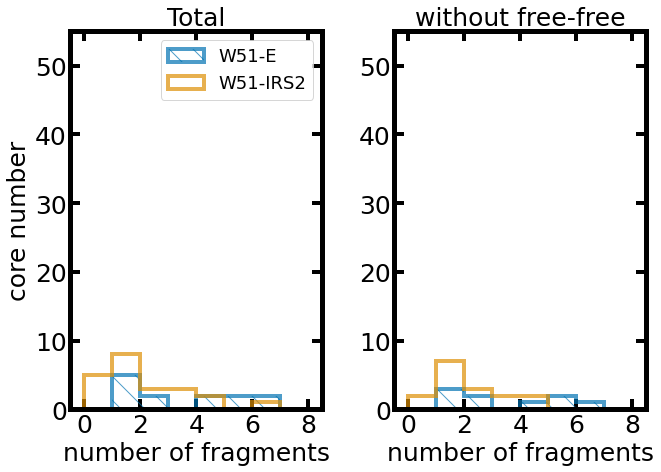

In [3]:
import seaborn as sns
import matplotlib as mpl
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
bins = np.arange(11)

print(multiplicity_w51e_b3fov)
numarr_w51e = multiplicity_w51e_b3fov[0]
numarr_w51n = multiplicity_w51n_b3fov[0]
numarr_w51e_woff = multiplicity_w51e_b3fov_woff[0]
numarr_w51n_woff = multiplicity_w51n_b3fov_woff[0]

cmap = sns.color_palette("colorblind")

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_axes([0.1,0.17,0.35,0.75])
ax2 = fig.add_axes([0.55,0.17,0.35,0.75])

#ax1.hist(numarr_w51e_b3fov, bins = bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E',lw=4,alpha=0.8)
#ax1.hist(numarr_w51n_b3fov, bins = bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2',lw=4,alpha=0.8)
ax1.hist(numarr_w51e, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
ax1.hist(numarr_w51n, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
ax2.hist(numarr_w51e_woff, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
ax2.hist(numarr_w51n_woff, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
print(np.histogram(numarr_w51e,bins=bins)[0],np.histogram(numarr_w51n,bins=bins)[0])
print(np.histogram(numarr_w51e_woff,bins=bins)[0],np.histogram(numarr_w51n_woff,bins=bins)[0])

ax1.set_xlabel('number of fragments')
ax2.set_xlabel('number of fragments')

ax1.set_ylabel('core number')
ax1.set_title('Total')
ax2.set_title('without free-free')
ax1.legend(fontsize=18)
ax1.set_ylim(0,55)
ax2.set_ylim(0,55)
ax1.set_xlim(-0.5,8.5)
ax2.set_xlim(-0.5,8.5)
ax1.set_xticks([0,2,4,6,8])
ax2.set_xticks([0,2,4,6,8])

plt.savefig('frag_count.pdf')





([1, 1, 1, 5, 6, 6, 4, 2, 4, 2, 5, 1, 1], [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14], [[41], [40], [134], [30, 31, 32, 33, 34], [46, 48, 50, 51, 54, 56], [52, 55, 58, 59, 60, 61], [8, 9, 10, 85], [37, 102], [1, 2, 3, 83], [53, 57], [70, 71, 82, 123, 124], [65], [35]], [], [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14])
[0 5 2 0 2 2 2 0 0 0] [5 8 3 3 2 0 1 0 0 0]
[0 3 2 0 1 2 1 0 0 0] [2 7 3 2 2 0 0 0 0 0]


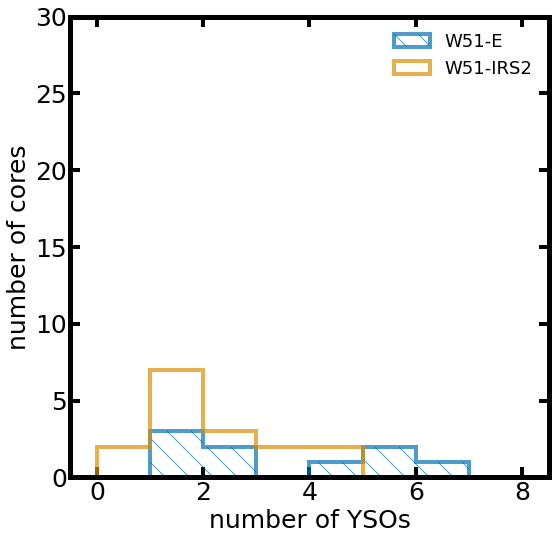

In [4]:
import seaborn as sns
import matplotlib as mpl
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
bins = np.arange(11)

print(multiplicity_w51e_b3fov)
numarr_w51e = multiplicity_w51e_b3fov[0]
numarr_w51n = multiplicity_w51n_b3fov[0]
numarr_w51e_woff = multiplicity_w51e_b3fov_woff[0]
numarr_w51n_woff = multiplicity_w51n_b3fov_woff[0]

cmap = sns.color_palette("colorblind")

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.15,0.17,0.83,0.8])

#ax1.hist(numarr_w51e_b3fov, bins = bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E',lw=4,alpha=0.8)
#ax1.hist(numarr_w51n_b3fov, bins = bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2',lw=4,alpha=0.8)
#ax1.hist(numarr_w51e, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
#ax1.hist(numarr_w51n, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
ax1.hist(numarr_w51e_woff, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
ax1.hist(numarr_w51n_woff, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
print(np.histogram(numarr_w51e,bins=bins)[0],np.histogram(numarr_w51n,bins=bins)[0])
print(np.histogram(numarr_w51e_woff,bins=bins)[0],np.histogram(numarr_w51n_woff,bins=bins)[0])

ax1.set_xlabel('number of YSOs')
#ax2.set_xlabel('number of fragments')

ax1.set_ylabel('number of cores')
#ax1.set_title('Total')
#ax2.set_title('without free-free')
ax1.legend(fontsize=18, frameon=False)
ax1.set_ylim(0,30)
#ax2.set_ylim(0,55)
ax1.set_xlim(-0.5,8.5)
#ax2.set_xlim(-0.5,8.5)
ax1.set_xticks([0,2,4,6,8])
#ax2.set_xticks([0,2,4,6,8])

plt.savefig('frag_count.pdf')





hoho
8
9
hoho
5
16
ysoindarr_w51e_b3fov_woff  [[40], [30, 31, 32, 33, 34], [52, 55, 58, 59, 60, 61], [37, 102], [1, 2, 3, 83], [53, 57], [70, 71, 82, 123, 124], [65], [35]]
id, mass [40] MBBT_mass
 solMass 
---------
       --
id, mass [30, 31, 32, 33, 34]     MBBT_mass     
     solMass      
------------------
 8.144783804883563
6.1554403374693925
10.166644852168488
                --
                --
id, mass [52, 55, 58, 59, 60, 61]     MBBT_mass     
     solMass      
------------------
                --
 5.613015112910818
 3.313933439596941
11.708387579302357
14.968923800838217
 5.425184543105075
id, mass [37, 102] MBBT_mass
 solMass 
---------
       --
       --
id, mass [1, 2, 3, 83]     MBBT_mass     
     solMass      
------------------
 9.639377332333344
 7.177750180069746
0.9224622552317727
                --
id, mass [53, 57]     MBBT_mass     
     solMass      
------------------
 5.663664557090761
4.7006636897982705
id, mass [70, 71, 82, 123, 124]     MBBT_mass   

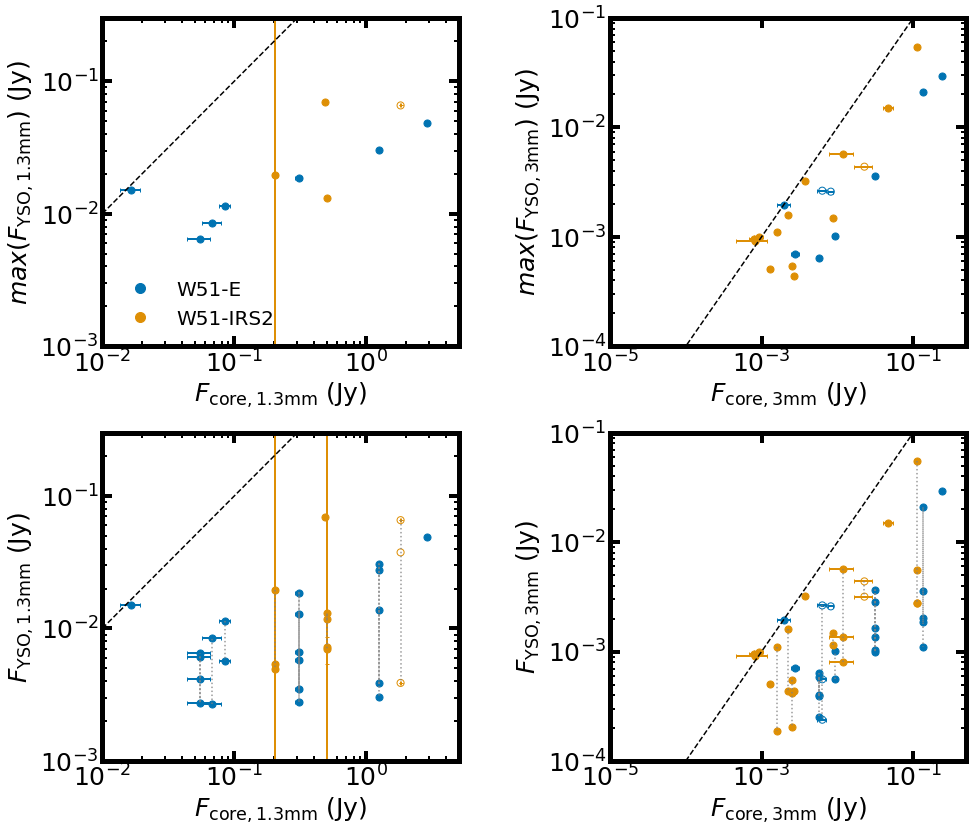

In [5]:
from matplotlib.lines import Line2D
from add_asym import add_asym

w51e_b6_flux_file = '/home/t.yoo/w51/catalogue/photometry/flux_new/w51e_b6_test.fits'
w51e_b3_flux_file = '/home/t.yoo/w51/catalogue/photometry/flux_new/w51e_b3_test.fits'
w51n_b6_flux_file= '/home/t.yoo/w51/catalogue/photometry/flux_new/w51n_b6_test.fits'
w51n_b3_flux_file = '/home/t.yoo/w51/catalogue/photometry/flux_new/w51n_b3_test.fits'
w51e_b6_conv_flux_file = '/home/t.yoo/w51/catalogue/photometry/flux_new/w51e_b6_conv_test.fits'
w51n_b6_conv_flux_file = '/home/t.yoo/w51/catalogue/photometry/flux_new/w51n_b6_conv_test.fits'

w51e_b6_flux_fits = Table.read(w51e_b6_flux_file)
w51e_b3_flux_fits = Table.read(w51e_b3_flux_file)
w51n_b6_flux_fits = Table.read(w51n_b6_flux_file)
w51n_b3_flux_fits = Table.read(w51n_b3_flux_file)
w51e_b6_conv_flux_fits = Table.read(w51e_b6_conv_flux_file)
w51n_b6_conv_flux_fits = Table.read(w51n_b6_conv_flux_file)



ysoflux_err_b6_w51e = w51e_b6_flux_fits['flux_err'] 
ysoflux_err_b3_w51e = w51e_b3_flux_fits['flux_err'] 


ysoflux_err_b6_w51n =  w51n_b6_flux_fits['flux_err'] 
ysoflux_err_b3_w51n =  w51n_b3_flux_fits['flux_err']  

ysoflux_b6_w51e = w51e_b6_flux_fits['flux']
ysoflux_b3_w51e = w51e_b3_flux_fits['flux']
ysoflux_b6_w51n = w51n_b6_flux_fits['flux']
ysoflux_b3_w51n = w51n_b3_flux_fits['flux']


ysoflux_b6_w51e = np.array([np.nan if flux<0 else flux for flux in ysoflux_b6_w51e])
ysoflux_b3_w51e = np.array([np.nan if flux<0 else flux for flux in ysoflux_b3_w51e])
ysoflux_b6_w51n = np.array([np.nan if flux<0 else flux for flux in ysoflux_b6_w51n])
ysoflux_b3_w51n = np.array([np.nan if flux<0 else flux for flux in ysoflux_b3_w51n])

coreindarr_w51e_b3fov = multiplicity_w51e_b3fov[1]
coreindarr_w51n_b3fov = multiplicity_w51n_b3fov[1]

coreindarr_w51e_b3fov_woff = multiplicity_w51e_b3fov_woff[1]
coreindarr_w51n_b3fov_woff = multiplicity_w51n_b3fov_woff[1]

coreindarr_w51e_b3fov_wff = multiplicity_w51e_b3fov_wff[1]
coreindarr_w51n_b3fov_wff = multiplicity_w51n_b3fov_wff[1]

coreindarr_w51e_b6fov = multiplicity_w51e_b6fov[1]
coreindarr_w51n_b6fov = multiplicity_w51n_b6fov[1]

coreindarr_w51e_b6fov_woff = multiplicity_w51e_b6fov_woff[1]
coreindarr_w51n_b6fov_woff = multiplicity_w51n_b6fov_woff[1]

coreindarr_w51e_b6fov_wff = multiplicity_w51e_b6fov_wff[1]
coreindarr_w51n_b6fov_wff = multiplicity_w51n_b6fov_wff[1]

ysoindarr_w51e_b3fov = multiplicity_w51e_b3fov[2]
ysoindarr_w51n_b3fov = multiplicity_w51n_b3fov[2]

ysoindarr_w51e_b3fov_woff = multiplicity_w51e_b3fov_woff[2]
ysoindarr_w51n_b3fov_woff = multiplicity_w51n_b3fov_woff[2]

ysoindarr_w51e_b3fov_wff = multiplicity_w51e_b3fov_wff[2]
ysoindarr_w51n_b3fov_wff = multiplicity_w51n_b3fov_wff[2]

ysoindarr_w51e_b6fov = multiplicity_w51e_b6fov[2]
ysoindarr_w51n_b6fov = multiplicity_w51n_b6fov[2]

ysoindarr_w51e_b6fov_woff = multiplicity_w51e_b6fov_woff[2]
ysoindarr_w51n_b6fov_woff = multiplicity_w51n_b6fov_woff[2]

ysoindarr_w51e_b6fov_wff = multiplicity_w51e_b6fov_wff[2]
ysoindarr_w51n_b6fov_wff = multiplicity_w51n_b6fov_wff[2]



def flatten(xss):
    return [x for xs in xss for x in xs]

### save the data

isinsidecore_w51e_b3fov_woff = np.zeros(len(catalog_w51e_yso['b3_xsky']),dtype=bool)
isinsidecore_w51e_b3fov_woff[flatten(ysoindarr_w51e_b3fov_woff)] = True
catalog_w51e_yso['isinsidecore_woff_b3fov'] = isinsidecore_w51e_b3fov_woff

isinsidecore_w51e_b3fov = np.zeros(len(catalog_w51e_yso['b3_xsky']),dtype=bool)
isinsidecore_w51e_b3fov[flatten(ysoindarr_w51e_b3fov)] = True
catalog_w51e_yso['isinsidecore_b3fov'] = isinsidecore_w51e_b3fov

isinsidecore_w51e_b6fov_woff = np.zeros(len(catalog_w51e_yso['b6_xsky']),dtype=bool)
isinsidecore_w51e_b6fov_woff[flatten(ysoindarr_w51e_b6fov_woff) ] = True
catalog_w51e_yso['isinsidecore_woff_b6fov'] = isinsidecore_w51e_b6fov_woff

isinsidecore_w51e_b6fov = np.zeros(len(catalog_w51e_yso['b6_xsky']),dtype=bool)
isinsidecore_w51e_b6fov[flatten(ysoindarr_w51e_b6fov)] = True
catalog_w51e_yso['isinsidecore_b6fov'] = isinsidecore_w51e_b6fov

isinsidecore_w51n_b3fov_woff = np.zeros(len(catalog_w51n_yso['b3_xsky']),dtype=bool)
isinsidecore_w51n_b3fov_woff[flatten(ysoindarr_w51n_b3fov_woff) ] = True
catalog_w51n_yso['isinsidecore_woff_b3fov'] = isinsidecore_w51n_b3fov_woff

isinsidecore_w51n_b3fov = np.zeros(len(catalog_w51n_yso['b3_xsky']),dtype=bool)
isinsidecore_w51n_b3fov[flatten(ysoindarr_w51n_b3fov)] = True
catalog_w51n_yso['isinsidecore_b3fov'] = isinsidecore_w51n_b3fov

isinsidecore_w51n_b6fov_woff = np.zeros(len(catalog_w51n_yso['b6_xsky']),dtype=bool)
isinsidecore_w51n_b6fov_woff[flatten(ysoindarr_w51n_b6fov_woff) ] = True
catalog_w51n_yso['isinsidecore_woff_b6fov'] = isinsidecore_w51n_b6fov_woff

isinsidecore_w51n_b6fov = np.zeros(len(catalog_w51n_yso['b6_xsky']),dtype=bool)
isinsidecore_w51n_b6fov[flatten(ysoindarr_w51n_b6fov)] = True
catalog_w51n_yso['isinsidecore_b6fov'] = isinsidecore_w51n_b6fov

catalog_w51e_yso.write(Path.w51e_dendro_matched_catalog, overwrite=True)
catalog_w51n_yso.write(Path.w51n_dendro_matched_catalog, overwrite=True)

###

coreflux_w51e_b6_b6fov_woff = core_flux_w51e_b6[coreindarr_w51e_b6fov_woff]


coreflux_w51e_b3_b3fov_woff = core_flux_w51e_b3[coreindarr_w51e_b3fov_woff]
coreflux_w51n_b6_b6fov_woff = core_flux_w51n_b6[coreindarr_w51n_b6fov_woff]
coreflux_w51n_b3_b3fov_woff = core_flux_w51n_b3[coreindarr_w51n_b3fov_woff]

coreflux_w51e_b6_b6fov_wff = core_flux_w51e_b6[coreindarr_w51e_b6fov_wff]
coreflux_w51e_b3_b3fov_wff = core_flux_w51e_b3[coreindarr_w51e_b3fov_wff]
coreflux_w51n_b6_b6fov_wff = core_flux_w51n_b6[coreindarr_w51n_b6fov_wff]
coreflux_w51n_b3_b3fov_wff = core_flux_w51n_b3[coreindarr_w51n_b3fov_wff]
print('hoho')
print(len(coreflux_w51e_b6_b6fov_woff))
print(len(coreflux_w51e_b3_b3fov_woff))
print('hoho')
print(len(coreflux_w51n_b6_b6fov_woff))
print(len(coreflux_w51n_b3_b3fov_woff))
corefluxerr_w51e_b6_b6fov_woff = core_fluxerr_w51e_b6[coreindarr_w51e_b6fov_woff]
corefluxerr_w51e_b3_b3fov_woff = core_fluxerr_w51e_b3[coreindarr_w51e_b3fov_woff]

corefluxerr_w51n_b6_b6fov_woff = core_fluxerr_w51n_b6[coreindarr_w51n_b6fov_woff]
corefluxerr_w51n_b3_b3fov_woff = core_fluxerr_w51n_b3[coreindarr_w51n_b3fov_woff]

corefluxerr_w51e_b6_b6fov_wff = core_fluxerr_w51e_b6[coreindarr_w51e_b6fov_woff]
corefluxerr_w51e_b3_b3fov_wff = core_fluxerr_w51e_b3[coreindarr_w51e_b3fov_woff]

corefluxerr_w51n_b6_b6fov_wff = core_fluxerr_w51n_b6[coreindarr_w51n_b6fov_wff]
corefluxerr_w51n_b3_b3fov_wff = core_fluxerr_w51n_b3[coreindarr_w51n_b3fov_wff]

coremass_w51e_b6fov_woff = coremass_w51e[coreindarr_w51e_b6fov_woff]
coremass_w51e_b3fov_woff = coremass_w51e[coreindarr_w51e_b3fov_woff]

coremass_w51n_b6fov_woff = coremass_w51n[coreindarr_w51n_b6fov_woff]
coremass_w51n_b3fov_woff = coremass_w51n[coreindarr_w51n_b3fov_woff]

coremass_w51e_b6fov_wff = coremass_w51e[coreindarr_w51e_b6fov_wff]
coremass_w51e_b3fov_wff = coremass_w51e[coreindarr_w51e_b3fov_wff]

coremass_w51n_b6fov_wff = coremass_w51n[coreindarr_w51n_b6fov_wff]
coremass_w51n_b3fov_wff = coremass_w51n[coreindarr_w51n_b3fov_wff]

coremasserr_w51e_b6fov_woff = coremasserr_w51e[coreindarr_w51e_b6fov_woff]
coremasserr_w51e_b3fov_woff = coremasserr_w51e[coreindarr_w51e_b3fov_woff]

coremasserr_w51n_b6fov_woff = coremasserr_w51n[coreindarr_w51n_b6fov_woff]
coremasserr_w51n_b3fov_woff = coremasserr_w51n[coreindarr_w51n_b3fov_woff]

coremasserr_w51e_b6fov_wff = coremasserr_w51e[coreindarr_w51e_b6fov_wff]
coremasserr_w51e_b3fov_wff = coremasserr_w51e[coreindarr_w51e_b3fov_wff]

coremasserr_w51n_b6fov_wff = coremasserr_w51n[coreindarr_w51n_b6fov_wff]
coremasserr_w51n_b3fov_wff = coremasserr_w51n[coreindarr_w51n_b3fov_wff]

coretemp_w51e_b6fov_woff = coretemp_w51e[coreindarr_w51e_b6fov_woff]
coretemp_w51e_b3fov_woff = coretemp_w51e[coreindarr_w51e_b3fov_woff]
coretemp_w51n_b6fov_woff = coretemp_w51n[coreindarr_w51n_b6fov_woff]
coretemp_w51n_b3fov_woff = coretemp_w51n[coreindarr_w51n_b3fov_woff]

coretemp_w51e_b6fov_wff = coretemp_w51e[coreindarr_w51e_b6fov_wff]
coretemp_w51e_b3fov_wff = coretemp_w51e[coreindarr_w51e_b3fov_wff]
coretemp_w51n_b6fov_wff = coretemp_w51n[coreindarr_w51n_b6fov_wff]
coretemp_w51n_b3fov_wff = coretemp_w51n[coreindarr_w51n_b3fov_wff]


ysomass_constT_w51e = catalog_w51e_yso['constT_mass']
ysomass_constT_w51n = catalog_w51n_yso['constT_mass']
ysomass_MBBT_w51e = catalog_w51e_yso['MBBT_mass']
ysomass_MBBT_w51n = catalog_w51n_yso['MBBT_mass']

ysomass_err_constT_w51e = catalog_w51e_yso['constT_mass_err']
ysomass_err_constT_w51n = catalog_w51n_yso['constT_mass_err']
ysomass_err_MBBT_w51e = catalog_w51e_yso['MBBT_mass_err']
ysomass_err_MBBT_w51n = catalog_w51n_yso['MBBT_mass_err']

ysoflux_w51e_b6_b6fov_woff = [ysoflux_b6_w51e[ind] for ind in ysoindarr_w51e_b6fov_woff]
ysoflux_w51e_b3_b3fov_woff = [ysoflux_b3_w51e[ind] for ind in ysoindarr_w51e_b3fov_woff] 
ysoflux_w51e_b6_b6fov_woff = [ysoflux_b6_w51e[ind] for ind in ysoindarr_w51e_b6fov_woff]
ysoflux_w51e_b3_b3fov_woff = [ysoflux_b3_w51e[ind] for ind in ysoindarr_w51e_b3fov_woff] 




ysoflux_w51n_b6_b6fov_woff = [ysoflux_b6_w51n[ind] for ind in ysoindarr_w51n_b6fov_woff]
ysoflux_w51n_b3_b3fov_woff = [ysoflux_b3_w51n[ind] for ind in ysoindarr_w51n_b3fov_woff] 
ysoflux_w51n_b6_b6fov_woff = [ysoflux_b6_w51n[ind] for ind in ysoindarr_w51n_b6fov_woff]
ysoflux_w51n_b3_b3fov_woff = [ysoflux_b3_w51n[ind] for ind in ysoindarr_w51n_b3fov_woff] 

ysoflux_err_w51e_b6_b6fov_woff = [ysoflux_err_b6_w51e[ind].value for ind in ysoindarr_w51e_b6fov_woff]
ysoflux_err_w51e_b3_b3fov_woff = [ysoflux_err_b3_w51e[ind].value for ind in ysoindarr_w51e_b3fov_woff] 

ysoflux_err_w51n_b6_b6fov_woff = [ysoflux_err_b6_w51n[ind].value for ind in ysoindarr_w51n_b6fov_woff]
ysoflux_err_w51n_b3_b3fov_woff = [ysoflux_err_b3_w51n[ind].value for ind in ysoindarr_w51n_b3fov_woff] 

ysoflux_w51e_b6_b6fov_wff = [ysoflux_b6_w51e[ind] for ind in ysoindarr_w51e_b6fov_wff]
ysoflux_w51e_b3_b3fov_wff = [ysoflux_b3_w51e[ind] for ind in ysoindarr_w51e_b3fov_wff] 
ysoflux_w51e_b6_b6fov_wff = [ysoflux_b6_w51e[ind] for ind in ysoindarr_w51e_b6fov_wff]
ysoflux_w51e_b3_b3fov_wff = [ysoflux_b3_w51e[ind] for ind in ysoindarr_w51e_b3fov_wff] 

ysoflux_w51n_b6_b6fov_wff = [ysoflux_b6_w51n[ind] for ind in ysoindarr_w51n_b6fov_wff]
ysoflux_w51n_b3_b3fov_wff = [ysoflux_b3_w51n[ind] for ind in ysoindarr_w51n_b3fov_wff] 
ysoflux_w51n_b6_b6fov_wff = [ysoflux_b6_w51n[ind] for ind in ysoindarr_w51n_b6fov_wff]
ysoflux_w51n_b3_b3fov_wff = [ysoflux_b3_w51n[ind] for ind in ysoindarr_w51n_b3fov_wff] 

ysoflux_err_w51e_b6_b6fov_wff = [ysoflux_err_b6_w51e[ind].value for ind in ysoindarr_w51e_b6fov_wff]
ysoflux_err_w51e_b3_b3fov_wff = [ysoflux_err_b3_w51e[ind].value for ind in ysoindarr_w51e_b3fov_wff] 

ysoflux_err_w51n_b6_b6fov_wff = [ysoflux_err_b6_w51n[ind].value for ind in ysoindarr_w51n_b6fov_wff]
ysoflux_err_w51n_b3_b3fov_wff = [ysoflux_err_b3_w51n[ind].value for ind in ysoindarr_w51n_b3fov_wff] 
print('ysoindarr_w51e_b3fov_woff ', ysoindarr_w51e_b3fov_woff, )
for ind in ysoindarr_w51e_b3fov_woff:
    print('id, mass',ind, ysomass_MBBT_w51e[ind])
for ind in ysoindarr_w51e_b3fov:
    print('id2, mas2s',ind, ysomass_MBBT_w51e[ind])
ysomass_constT_w51e_b6fov_woff = [ysomass_constT_w51e[ind].value for ind in ysoindarr_w51e_b6fov_woff]
ysomass_constT_w51e_b3fov_woff = [ysomass_constT_w51e[ind].value for ind in ysoindarr_w51e_b3fov_woff] 
ysomass_MBBT_w51e_b6fov_woff = [ysomass_MBBT_w51e[ind].value for ind in ysoindarr_w51e_b6fov_woff]
ysomass_MBBT_w51e_b3fov_woff = [ysomass_MBBT_w51e[ind].value for ind in ysoindarr_w51e_b3fov_woff] 

ysomass_constT_w51n_b6fov_woff = [ysomass_constT_w51n[ind].value for ind in ysoindarr_w51n_b6fov_woff]
ysomass_constT_w51n_b3fov_woff = [ysomass_constT_w51n[ind].value for ind in ysoindarr_w51n_b3fov_woff] 
ysomass_MBBT_w51n_b6fov_woff = [ysomass_MBBT_w51n[ind].value for ind in ysoindarr_w51n_b6fov_woff]
ysomass_MBBT_w51n_b3fov_woff = [ysomass_MBBT_w51n[ind].value for ind in ysoindarr_w51n_b3fov_woff] 


ysomass_err_constT_w51e_b6fov_woff = [ysomass_err_constT_w51e[ind].value for ind in ysoindarr_w51e_b6fov_woff]
ysomass_err_constT_w51e_b3fov_woff = [ysomass_err_constT_w51e[ind].value for ind in ysoindarr_w51e_b3fov_woff] 
ysomass_err_constT_w51n_b6fov_woff = [ysomass_err_constT_w51n[ind].value for ind in ysoindarr_w51n_b6fov_woff]
ysomass_err_constT_w51n_b3fov_woff = [ysomass_err_constT_w51n[ind].value for ind in ysoindarr_w51n_b3fov_woff] 

ysomass_err_MBBT_w51e_b6fov_woff = [ysomass_err_MBBT_w51e[ind].value for ind in ysoindarr_w51e_b6fov_woff]
ysomass_err_MBBT_w51e_b3fov_woff = [ysomass_err_MBBT_w51e[ind].value for ind in ysoindarr_w51e_b3fov_woff] 
ysomass_err_MBBT_w51n_b6fov_woff = [ysomass_err_MBBT_w51n[ind].value for ind in ysoindarr_w51n_b6fov_woff]
ysomass_err_MBBT_w51n_b3fov_woff = [ysomass_err_MBBT_w51n[ind].value for ind in ysoindarr_w51n_b3fov_woff] 
    

def plot_core_yso_all_frags(ax, coredats, ysodats, coredats_err, ysodats_err, color='c'):
    count=0
    print('plot_core_yso_all_frags')
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            count =count+1
            lenx = len(ysodats[i])
            #if not any(~np.isfinite(ysodats[i])):
            #    print(np.max(ysodats[i])/np.sort(ysodats[i]))
            for j in range(lenx):
                if np.isfinite(ysodats[i][j]) and np.isfinite(ysodats_err[i][j]):
                    ax.errorbar(coredat, ysodats[i][j], xerr = coredats_err[i], 
                                yerr=ysodats_err[i][j],
                                capsize=2.0, elinewidth=2, ecolor=color)
            
            print(i, ysodats[i],np.isfinite(ysodats[i]),len(np.where(np.isfinite(ysodats[i])==True)[0]))    
            if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                ax.plot(np.ones(lenx)*coredat, ysodats[i], ls='dotted', color='gray',alpha=0.8)
                ax.scatter(np.ones(lenx)*coredat, ysodats[i], marker='o', facecolor='none', color=color, s=50)
            else:
                ax.plot(np.ones(lenx)*coredat, ysodats[i], ls='dotted', color='gray',alpha=0.8)
                ax.scatter(np.ones(lenx)*coredat, ysodats[i],marker='o', color=color, s=50)
def plot_core_yso_sum_frags(ax, coredats, ysodats, coredats_err,ysodats_err, color='c'):
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            #yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)

            if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                ax.scatter(coredat, np.nansum(ysodats[i]),color=color, marker='o', facecolor='none',s=50)
                ax.errorbar(coredat, np.nansum(ysodats[i]), xerr=coredats_err[i], 
                            yerr=np.linalg.norm(ysodats_err[i]),
                           capsize=2.0, elinewidth=2, ecolor=color)
            else:
                ax.scatter(coredat, np.nansum(ysodats[i]),color=color, marker='o',s=50)
                ax.errorbar(coredat, np.nansum(ysodats[i]), xerr=coredats_err[i], 
                           yerr=np.linalg.norm(ysodats_err[i]),
                           capsize=2.0, elinewidth=2, ecolor=color)
            """
            else:
                ax.scatter(coredat, np.nansum(ysodats[i]),color=color, marker='o',s=50)
                ax.errorbar(coredat, yerrset[0], xerr=coredats_err[i], 
                            yerr=np.array([[np.abs(yerrset[1]),yerrset[2]]]).T,
                           capsize=2.0, elinewidth=2, ecolor=color)
            """
                
            
def plot_core_yso_max_frags(ax, coredats, ysodats, coredats_err, ysodats_err, color='c'):
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                    ax.errorbar(coredat, np.nanmax(ysodats[i]), xerr = coredats_err[i], 
                                    yerr=ysodats_err[i][np.nanargmax(ysodats[i])],
                                capsize=2.0, elinewidth=2, ecolor=color)
                    ax.scatter(coredat, np.nanmax(ysodats[i]),color=color,s=50, marker='o', facecolor='none')

                else:
                    ax.errorbar(coredat, np.nanmax(ysodats[i]), xerr = coredats_err[i], 
                                    yerr=ysodats_err[i][np.nanargmax(ysodats[i])],
                                capsize=2.0, elinewidth=2, ecolor=color)
                    ax.scatter(coredat, np.nanmax(ysodats[i]),color=color,s=50, marker='o')
                """
                if any(~np.isfinite(ysodats[i])):
                    ax.errorbar(coredat, np.nanmax(ysodats[i]), xerr = coredats_err[i], 
                                    yerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                    ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                                capsize=2.0, elinewidth=2, ecolor=color)
                    ax.scatter(coredat, np.nanmax(ysodats[i]),color=color,s=50, marker='o', facecolor='none')

                else:
                    ax.errorbar(coredat, np.nanmax(ysodats[i]), xerr = coredats_err[i], 
                                    yerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                    ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                                capsize=2.0, elinewidth=2, ecolor=color)
                    ax.scatter(coredat, np.nanmax(ysodats[i]),color=color,s=50, marker='o')
                """

            

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_axes([0.15,0.1,0.33,0.38])
ax2 = fig.add_axes([0.62,0.1,0.33,0.38])

#ax3 = fig.add_axes([0.1,0.41,0.38,0.25])
#ax4 = fig.add_axes([0.58,0.41,0.38,0.25])

ax5 = fig.add_axes([0.15,0.58,0.33,0.38])
ax6 = fig.add_axes([0.62,0.58,0.33,0.38])

plot_core_yso_all_frags(ax1, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff, corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff  ,color=cmap[0])
plot_core_yso_all_frags(ax2, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff ,color=cmap[0])
plot_core_yso_all_frags(ax1, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff, corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff  ,color=cmap[1])
plot_core_yso_all_frags(ax2, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff ,color=cmap[1])


#plot_core_yso_sum_frags(ax3, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff, color=cmap[0])
#plot_core_yso_sum_frags(ax4, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff, color=cmap[0])
#plot_core_yso_sum_frags(ax3, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff, color=cmap[1])
#plot_core_yso_sum_frags(ax4, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff, color=cmap[1])

plot_core_yso_max_frags(ax5, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff, corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff, color=cmap[0])
plot_core_yso_max_frags(ax6, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff, color=cmap[0])
plot_core_yso_max_frags(ax5, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff, corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff, color=cmap[1])
plot_core_yso_max_frags(ax6, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff, color=cmap[1])


ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_ylim(1e-3,3e-1)
ax1.set_xlim(1e-2,5)
ax2.set_ylim(1e-4,1e-1)
ax2.set_xlim(1e-5,5e-1)
ax1.set_xlabel(r'$F_{\rm core, 1.3mm}$ (Jy)')
ax2.set_xlabel(r'$F_{\rm core, 3mm}$ (Jy)')
ax1.set_ylabel(r'$F_{\rm YSO, 1.3mm}$ (Jy)')
ax2.set_ylabel(r'$F_{\rm YSO, 3mm}$ (Jy)')


ax1.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
ax2.plot([1e-5,5e-1],[1e-5,5e-1], ls='dashed', c='k')
ax5.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
ax6.plot([1e-5,5e-1],[1e-5,5e-1], ls='dashed', c='k')


"""
ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax3.set_ylim(1e-3,3e-1)
ax3.set_xlim(1e-2,5)
ax4.set_ylim(1e-4,1e-1)
ax4.set_xlim(5e-4,5e-1)
ax3.set_xlabel(r'$F_{\rm core, 1.3mm}$ (Jy)')
ax4.set_xlabel(r'$F_{\rm core, 3mm}$ (Jy)')
ax3.set_ylabel(r'$sum(F_{\rm YSO, 1.3mm})$ (Jy)')
ax4.set_ylabel(r'$sum(F_{\rm YSO, 3mm})$ (Jy)')

"""
ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax5.set_ylim(1e-3,3e-1)
ax5.set_xlim(1e-2,5)
ax6.set_ylim(1e-4,1e-1)
ax6.set_xlim(1e-5,5e-1)
ax5.set_xlabel(r'$F_{\rm core, 1.3mm}$ (Jy)')
ax6.set_xlabel(r'$F_{\rm core, 3mm}$ (Jy)')
ax5.set_ylabel(r'$max(F_{\rm YSO, 1.3mm})$ (Jy)')
ax6.set_ylabel(r'$max(F_{\rm YSO, 3mm})$ (Jy)')

handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax5.legend(handles=handles,fontsize=20, frameon=False)
plt.savefig('core_ysoflux.png')


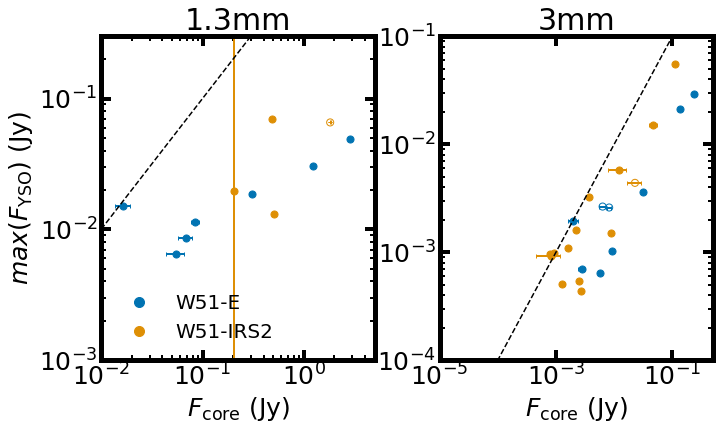

In [6]:
fig = plt.figure(figsize=(10,6))
ax5 = fig.add_axes([0.14,0.17,0.38,0.75])
ax6 = fig.add_axes([0.61,0.17,0.38,0.75])

plot_core_yso_max_frags(ax5, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff, corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff,color=cmap[0])
plot_core_yso_max_frags(ax6, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff  ,color=cmap[0])
plot_core_yso_max_frags(ax5, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff, corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff ,color=cmap[1])
plot_core_yso_max_frags(ax6, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff  ,   color=cmap[1])
ax5.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
ax6.plot([1e-5,5e-1],[1e-5,5e-1], ls='dashed', c='k')
                    
ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax5.set_ylim(1e-3,3e-1)
ax5.set_xlim(1e-2,5)
ax6.set_ylim(1e-4,1e-1)
ax6.set_xlim(1e-5,5e-1)
ax5.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax6.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax5.set_ylabel(r'$max(F_{\rm YSO})$ (Jy)')
#ax6.set_ylabel(r'$max(F_{\rm YSO, 3mm})$ (Jy)')

handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax5.legend(handles=handles,fontsize=20, frameon=False)
ax5.set_title('1.3mm',fontsize=30)
ax6.set_title('3mm',fontsize=30)
plt.savefig('core_ysofluxmax.png')

ho
plot_core_yso_all_frags
0 [0.04866729] [ True] 1
1 [0.01373557 0.00389436 0.0304842  0.02767051 0.00304388] [ True  True  True  True  True] 5
2 [0.01278052 0.00350943 0.00574892 0.01849917 0.00276993 0.0066138 ] [ True  True  True  True  True  True] 6
3 [0.01136841 0.00567577] [ True  True] 2
4 [0.00604779 0.00272649 0.00413014 0.00650093] [ True  True  True  True] 4
5 [0.00270308 0.00853543] [ True  True] 2
6 [0.01514592] [ True] 1
7 [0.00083912] [ True] 1
plot_core_yso_all_frags
0 [0.02933596] [ True] 1
1 [0.00187844 0.00203295 0.00354211 0.02103014 0.0011039 ] [ True  True  True  True  True] 5
2 [0.00281514 0.0009891  0.00104042 0.0036315  0.00164638 0.0013515 ] [ True  True  True  True  True  True] 6
3 [0.00258757        nan] [ True False] 1
4 [0.00264062 0.00055779 0.00023841        nan] [ True  True  True False] 3
5 [0.00055991 0.00101421] [ True  True] 2
6 [0.00064259 0.00040066 0.00039383 0.00058767 0.00025321] [ True  True  True  True  True] 5
7 [0.00193735] [ True] 1
8 [0.

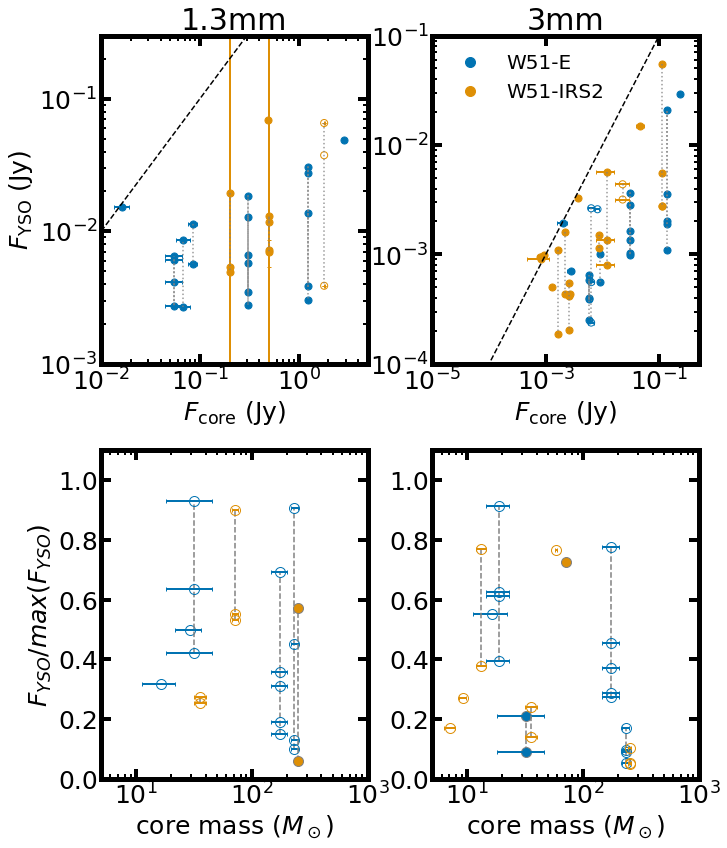

In [7]:
def plot_fluxratio_coremass(ax, coredats, ysodats, ysodats_err, coremass, coremasserr, color='c'):
    count=0
    for i, coredat in enumerate(coredats):
        
        if any(np.isfinite(ysodats[i])):
            lenx = len(ysodats[i])
            ysodat_sort = np.sort(ysodats[i])
            ysodat_sort_finite = ysodat_sort[np.isfinite(ysodat_sort)]

            ysodats_err_sort = ysodats_err[i][np.argsort(ysodats[i])]
            ysodats_err_sort_finite = ysodats_err[i][np.argsort(ysodats[i])]
            
            #ysodats_err_low_sort = ysodats_err_low[i][np.argsort(ysodats[i])]
            #ysodats_err_low_sort_finite = ysodats_err_low[i][np.isfinite(ysodats_err_low[i])]
            
            #ysodats_err_upp_sort = ysodats_err_upp[i][np.argsort(ysodats[i])]
            #ysodats_err_upp_sort_finite = ysodats_err_upp[i][np.isfinite(ysodats_err_upp[i])]

            if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                ax.plot(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), color='gray', mfc=color,ls='dashed',marker='o', markersize=10)
                ax.errorbar(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), 
                            xerr=coremasserr[i], 
                            #yerr=np.array(list(zip(ysodats_err_low_sort_finite[:-1], ysodats_err_upp_sort_finite[:-1]))).T,
                            capsize=2.0, elinewidth=2, ecolor=color,fmt='none')
                            
            else:
                ax.plot(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), color='gray',markeredgecolor=color, mfc='none',ls='dashed',marker='o', markersize=10)
                ax.errorbar(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), 
                            xerr=coremasserr[i], 
                            #yerr=np.array(list(zip(ysodats_err_low_sort_finite[:-1], ysodats_err_upp_sort_finite[:-1]))).T,
                            capsize=2.0, elinewidth=2, ecolor=color,fmt='none')
                    


fig = plt.figure(figsize=(10,12))
ax1 = fig.add_axes([0.14,0.1,0.37,0.38])
ax2 = fig.add_axes([0.6,0.1,0.37,0.38])

#ax3 = fig.add_axes([0.1,0.41,0.38,0.25])
#ax4 = fig.add_axes([0.58,0.41,0.38,0.25])

ax5 = fig.add_axes([0.14,0.58,0.37,0.38])
ax6 = fig.add_axes([0.6,0.58,0.37,0.38])

plot_fluxratio_coremass(ax1, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff ,coremass_w51e_b6fov_woff,coremasserr_w51e_b6fov_woff,color=cmap[0])
plot_fluxratio_coremass(ax1, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff, coremass_w51n_b6fov_woff, coremasserr_w51n_b6fov_woff,color=cmap[1])
print('ho')
plot_fluxratio_coremass(ax2, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, ysoflux_err_w51e_b3_b3fov_woff, coremass_w51e_b3fov_woff,coremasserr_w51e_b3fov_woff,color=cmap[0])
plot_fluxratio_coremass(ax2, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff, coremass_w51n_b3fov_woff,coremasserr_w51n_b3fov_woff,color=cmap[1])

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(5,1e3)
ax2.set_xlim(5,1e3)
ax1.set_ylim(0,1.1)
ax2.set_ylim(0,1.1)
ax1.set_xlabel(r'core mass ($M_\odot$)')
ax2.set_xlabel(r'core mass ($M_\odot$)')
ax1.set_ylabel(r'$F_{YSO}/max(F_{YSO})$')
#ax2.set_ylabel(r'$F_{3mm}/max(F_{3mm})$')

plot_core_yso_all_frags(ax5, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff, corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff, color=cmap[0])
plot_core_yso_all_frags(ax6, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff, color=cmap[0])
plot_core_yso_all_frags(ax5, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff, corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff, color=cmap[1])
plot_core_yso_all_frags(ax6, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff, color=cmap[1])
ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax5.set_ylim(1e-3,3e-1)
ax5.set_xlim(1e-2,5)
ax6.set_ylim(1e-4,1e-1)
ax6.set_xlim(1e-5,5e-1)

ax5.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax6.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax5.set_ylabel(r'$F_{\rm YSO}$ (Jy)')
#ax6.set_ylabel(r'$F_{\rm YSO, 3mm}$ (Jy)')
ax6.legend(handles=handles,fontsize=20, frameon=False)
ax5.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
ax6.plot([1e-5,5e-1],[1e-5,5e-1], ls='dashed', c='k')
ax5.set_title('1.3mm',fontsize=30)
ax6.set_title('3mm',fontsize=30)
plt.savefig('core_ysofluxall.png')

plot_core_yso_all_frags
0 [74.35814660546652] [True] 1
1 [4.7612921756066156 5.152940264020905 8.978226921067506 53.30531953906062
 2.798066026669613] [True True True True True] 5
2 [7.135563695340499 2.507089671766402 2.63715258411088 9.204801739967765
 4.173085391372478 3.425650717680848] [True True True True True True] 6
3 [6.558747293836164 --] [True --] 1
4 [6.6932175918668975 1.413823602535225 0.6042910170799364 --] [True True True --] 3
5 [1.4192015429017915 2.57073861280644] [True True] 2
6 [1.6287866411436749 1.015563505756257 0.9982492521531242 1.489560975947945
 0.6418182531206369] [True True True True True] 5
7 [4.910612941207685] [True] 1
8 [1.7848282823078756] [True] 1
plot_core_yso_all_frags
0 [123.4196586328473 12.60383658075289 6.231729510290009 6.241081541281201] [True True True True] 4
1 [33.61675188954897] [True] 1
2 [2.5684394884306307 3.359427947110246] [True True] 2
3 [9.859487910715906 7.152147731975647 -- --] [True True -- --] 2
4 [12.834973759320123 3.07916204

 [1.1385658598912252] [True] 1
14 [2.1464118263456062] [True] 1
15 [2.0593675788816217] [True] 1
plot_core_yso_all_frags
0 [--] [--] 0
1 [8.144783804883563 6.1554403374693925 10.166644852168488 -- --] [True True True -- --] 3
2 [-- 5.613015112910818 3.313933439596941 11.708387579302357
 14.968923800838217 5.425184543105075] [-- True True True True True] 5
3 [-- --] [-- --] 0
4 [9.639377332333344 7.177750180069746 0.9224622552317727 --] [True True True --] 3
5 [5.663664557090761 4.7006636897982705] [True True] 2
6 [2.769483982555001 3.1673753828392766 -- -- --] [True True -- -- --] 2
7 [4.059988477688907] [True] 1
8 [7.789073948090843] [True] 1
plot_core_yso_all_frags
0 [-- -- -- --] [-- -- -- --] 0
1 [--] [--] 0
2 [-- --] [-- --] 0
3 [-- -- -- --] [-- -- -- --] 0
4 [9.64803322186953 -- --] [True -- --] 1
5 [--] [--] 0
6 [--] [--] 0
7 [-- --] [-- --] 0
9 [--] [--] 0
10 [-- --] [-- --] 0
11 [-- -- --] [-- -- --] 0
13 [--] [--] 0
14 [--] [--] 0
15 [--] [--] 0


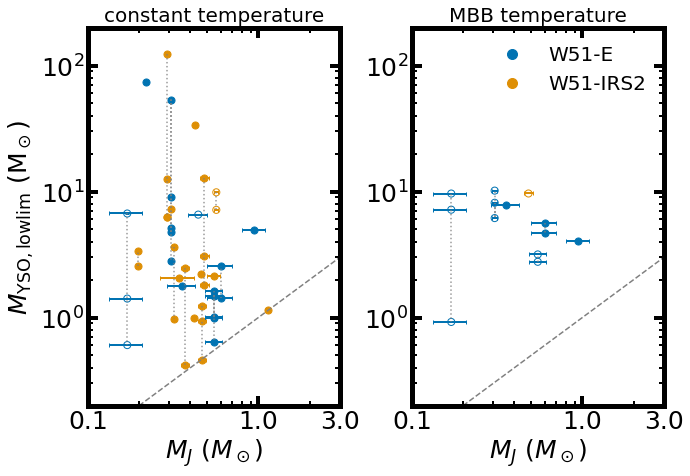

In [8]:
from matplotlib import ticker

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_axes([0.15,0.17,0.35,0.75])
ax2 = fig.add_axes([0.6,0.17,0.35,0.75])

jeansmass_w51e = core_catdata_w51e_b6.get_Jeansmass()
jeansmass_w51n = core_catdata_w51n_b6.get_Jeansmass(dist=5100)
jeansmasserr_w51e = core_catdata_w51e_b6.get_Jeansmasserr()
jeansmasserr_w51n = core_catdata_w51n_b6.get_Jeansmasserr(dist=5100)

jeansmass_w51e_b6fov_woff = jeansmass_w51e[coreindarr_w51e_b6fov_woff]
jeansmass_w51e_b3fov_woff = jeansmass_w51e[coreindarr_w51e_b3fov_woff]

jeansmass_w51n_b6fov_woff = jeansmass_w51n[coreindarr_w51n_b6fov_woff]
jeansmass_w51n_b3fov_woff = jeansmass_w51n[coreindarr_w51n_b3fov_woff]

jeansmass_w51e_b6fov_wff = jeansmass_w51e[coreindarr_w51e_b6fov_wff]
jeansmass_w51e_b3fov_wff = jeansmass_w51e[coreindarr_w51e_b3fov_wff]

jeansmass_w51n_b6fov_wff = jeansmass_w51n[coreindarr_w51n_b6fov_wff]
jeansmass_w51n_b3fov_wff = jeansmass_w51n[coreindarr_w51n_b3fov_wff]

jeansmasserr_w51e_b6fov_woff = jeansmasserr_w51e[coreindarr_w51e_b6fov_woff]
jeansmasserr_w51e_b3fov_woff = jeansmasserr_w51e[coreindarr_w51e_b3fov_woff]

jeansmasserr_w51n_b6fov_woff = jeansmasserr_w51n[coreindarr_w51n_b6fov_woff]
jeansmasserr_w51n_b3fov_woff = jeansmasserr_w51n[coreindarr_w51n_b3fov_woff]

jeansmasserr_w51e_b6fov_wff = jeansmasserr_w51e[coreindarr_w51e_b6fov_wff]
jeansmasserr_w51e_b3fov_wff = jeansmasserr_w51e[coreindarr_w51e_b3fov_wff]

jeansmasserr_w51n_b6fov_wff = jeansmasserr_w51n[coreindarr_w51n_b6fov_wff]
jeansmasserr_w51n_b3fov_wff = jeansmasserr_w51n[coreindarr_w51n_b3fov_wff]



ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(0.1,3)
ax2.set_xlim(0.1,3)
ax1.set_ylim(0.2,2e2)
ax2.set_ylim(0.2,2e2)
ax1.set_xlabel(r'$M_J$ ($M_\odot$)')
ax2.set_xlabel(r'$M_J$ ($M_\odot$)')
ax1.set_ylabel(r'$M_{\rm YSO}$')
protostellarind_w51e_b3fov_woff = [i for i, ind in enumerate(ysoindarr_w51e_b3fov_woff) if len(ind)>0]
protostellarind_w51n_b3fov_woff = [i for i, ind in enumerate(ysoindarr_w51n_b3fov_woff) if len(ind)>0]
#plot_core_yso_all_frags(ax5, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_woff, corefluxerr_w51e_b6_woff,  ysoflux_err_w51e_b6_woff, color=cmap[0])
plot_core_yso_all_frags(ax1, jeansmass_w51e[coreindarr_w51e_b3fov_woff], ysomass_constT_w51e_b3fov_woff,   jeansmasserr_w51e[coreindarr_w51e_b3fov_woff], ysomass_err_constT_w51e_b3fov_woff, color=cmap[0])
plot_core_yso_all_frags(ax1, jeansmass_w51n[coreindarr_w51n_b3fov_woff], ysomass_constT_w51n_b3fov_woff,  jeansmasserr_w51n[coreindarr_w51n_b3fov_woff], ysomass_err_constT_w51n_b3fov_woff, color=cmap[1])
plot_core_yso_all_frags(ax2, jeansmass_w51e[coreindarr_w51e_b3fov_woff], ysomass_MBBT_w51e_b3fov_woff,  jeansmasserr_w51e[coreindarr_w51e_b3fov_woff], ysomass_err_MBBT_w51e_b3fov_woff,color=cmap[0])
plot_core_yso_all_frags(ax2, jeansmass_w51n[coreindarr_w51n_b3fov_woff], ysomass_MBBT_w51n_b3fov_woff,   jeansmasserr_w51n[coreindarr_w51n_b3fov_woff], ysomass_err_MBBT_w51n_b3fov_woff,color=cmap[1])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax5.set_ylim(1e-3,3e-1)
#ax5.set_xlim(1e-2,5)
#ax6.set_ylim(1e-4,1e-1)
#ax6.set_xlim(5e-4,5e-1)

ax1.set_xlabel(r'$M_{J}$ $(M_\odot)$')
ax2.set_xlabel(r'$M_{J}$ $(M_\odot)$')
ax1.set_ylabel(r'$M_{\rm YSO, lowlim}$ (M$_\odot$)')
#ax6.set_ylabel(r'$F_{\rm YSO, 3mm}$ (Jy)')
ax2.legend(handles=handles,fontsize=20, frameon=False)
ax1.set_title('constant temperature',fontsize=20)
ax1.set_xticks([0.1,1,3])
ax2.set_xticks([0.1,1,3])
ax1.plot([0.1,3],[0.1,3], ls='dashed', c='gray')
ax2.plot([0.1,3],[0.1,3], ls='dashed', c='gray')


ax2.set_title('MBB temperature',fontsize=20)
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
plt.savefig('jeans.png')

14
2
9
0
[40.58 29.24]
[14.0085182  9.2133449] solMass
0.8666666666666667 0.050000000000000044 0.050000000000000044


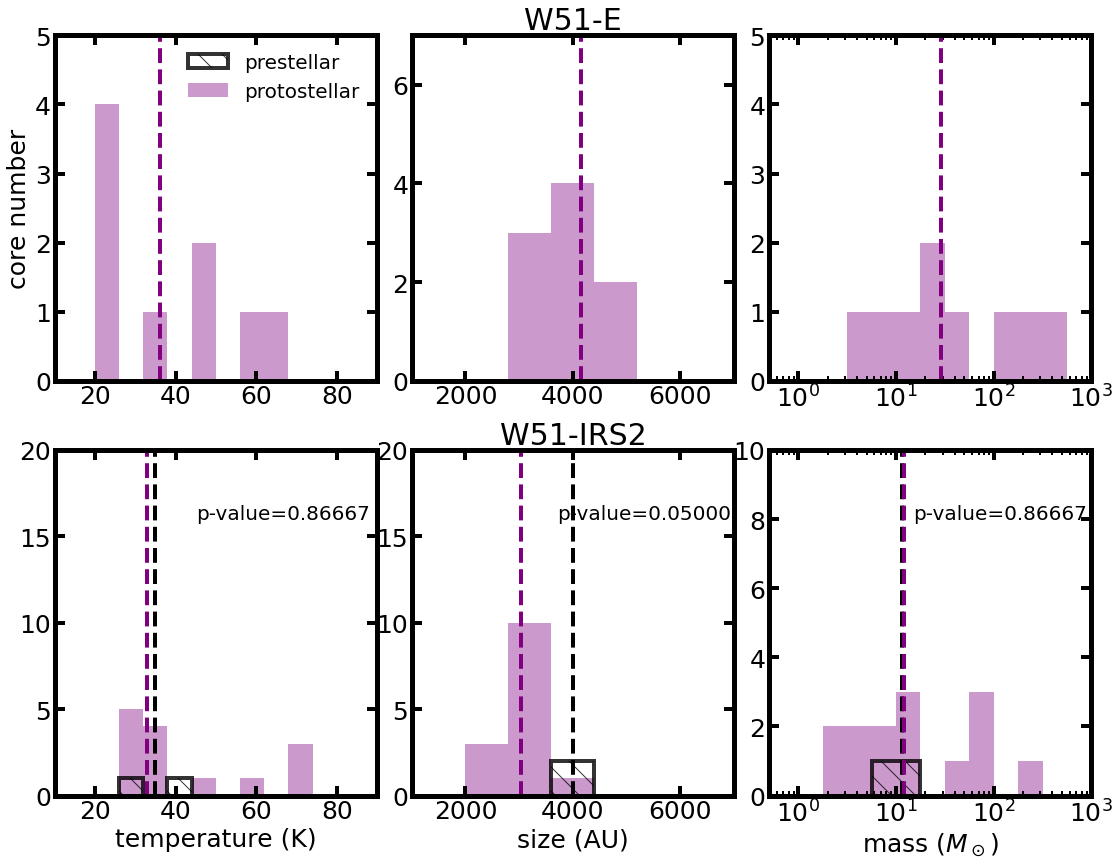

In [9]:
from scipy import stats

prestellar_w51e_b3fov_woff = multiplicity_w51e_b3fov_woff[3]
prestellar_w51n_b3fov_woff = multiplicity_w51n_b3fov_woff[3]
protostellar_w51e_b3fov_woff = multiplicity_w51e_b3fov_woff[4]
protostellar_w51n_b3fov_woff = multiplicity_w51n_b3fov_woff[4]


coremass_w51e_b3fov_woff_prestellar = coremass_w51e[prestellar_w51e_b3fov_woff]

coremass_w51n_b3fov_woff_prestellar = coremass_w51n[prestellar_w51n_b3fov_woff]
coremass_w51e_b3fov_woff_protostellar = coremass_w51e[protostellar_w51e_b3fov_woff]
coremass_w51n_b3fov_woff_protostellar = coremass_w51n[protostellar_w51n_b3fov_woff]

coremasserr_w51e_b3fov_woff_prestellar = coremasserr_w51e[prestellar_w51e_b3fov_woff]
coremasserr_w51n_b3fov_woff_prestellar = coremasserr_w51n[prestellar_w51n_b3fov_woff]
coremasserr_w51e_b3fov_woff_protostellar = coremasserr_w51e[protostellar_w51e_b3fov_woff]
coremasserr_w51n_b3fov_woff_protostellar = coremasserr_w51n[protostellar_w51n_b3fov_woff]

coretemp_w51e_b3fov_woff_prestellar = coretemp_w51e[prestellar_w51e_b3fov_woff]
coretemp_w51n_b3fov_woff_prestellar = coretemp_w51n[prestellar_w51n_b3fov_woff]
coretemp_w51e_b3fov_woff_protostellar = coretemp_w51e[protostellar_w51e_b3fov_woff]
coretemp_w51n_b3fov_woff_protostellar = coretemp_w51n[protostellar_w51n_b3fov_woff]

coresize_w51e_b3fov_woff_prestellar = core_size_w51e_b6[prestellar_w51e_b3fov_woff]
coresize_w51n_b3fov_woff_prestellar = core_size_w51n_b6[prestellar_w51n_b3fov_woff]
coresize_w51e_b3fov_woff_protostellar = core_size_w51e_b6[protostellar_w51e_b3fov_woff]
coresize_w51n_b3fov_woff_protostellar = core_size_w51n_b6[protostellar_w51n_b3fov_woff]
print(len(coresize_w51n_b3fov_woff_protostellar))
print(len(coresize_w51n_b3fov_woff_prestellar))
print(len(coresize_w51e_b3fov_woff_protostellar))
print(len(coresize_w51e_b3fov_woff_prestellar))

print(coretemp_w51n_b3fov_woff_prestellar)
print(coremass_w51n_b3fov_woff_prestellar)


fig = plt.figure(figsize=(16,12))

ax1 = fig.add_axes([0.08,0.07,0.28,0.4])
ax2 = fig.add_axes([0.39,0.07,0.28,0.4])
ax3 = fig.add_axes([0.7,0.07,0.28,0.4])
ax4 = fig.add_axes([0.08,0.55,0.28,0.4])
ax5 = fig.add_axes([0.39,0.55,0.28,0.4])
ax6 = fig.add_axes([0.7,0.55,0.28,0.4])

fluxbins=np.logspace(-0.5,1,num=11)

massbins=np.logspace(0,3,num=13)
sizebins=np.linspace(2000,10000,num=11)
tempbins=np.linspace(20,80,num=11)

ax3.hist(coremass_w51n_b3fov_woff_prestellar.value,bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar',lw=4)
ax3.hist(coremass_w51n_b3fov_woff_protostellar.value,bins=massbins, alpha=0.4, color='purple', label='protostellar',lw=4)
ax2.hist(coresize_w51n_b3fov_woff_prestellar,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar',lw=4)
ax2.hist(coresize_w51n_b3fov_woff_protostellar,bins=sizebins, alpha=0.4, color='purple', label='protostellar',lw=4)
ax1.hist(coretemp_w51n_b3fov_woff_prestellar,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar',lw=4)
ax1.hist(coretemp_w51n_b3fov_woff_protostellar,bins=tempbins, alpha=0.4, color='purple', label='protostellar',lw=4)

ax4.hist(coretemp_w51e_b3fov_woff_prestellar ,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar',lw=4)
ax4.hist(coretemp_w51e_b3fov_woff_protostellar,bins=tempbins, alpha=0.4, color='purple', label='protostellar',lw=4)
ax5.hist(coresize_w51e_b3fov_woff_prestellar,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar',lw=4)
ax5.hist(coresize_w51e_b3fov_woff_protostellar,bins=sizebins, alpha=0.4, color='purple', label='protostellar',lw=4)
ax6.hist(coremass_w51e_b3fov_woff_prestellar.value,bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar',lw=4)
ax6.hist(coremass_w51e_b3fov_woff_protostellar.value,bins=massbins, alpha=0.4, color='purple', label='protostellar',lw=4)

ax1.vlines(np.nanmedian(coretemp_w51n_b3fov_woff_prestellar), 0, 20, color='k', linestyle='dashed', lw=4)
ax1.vlines(np.nanmedian(coretemp_w51n_b3fov_woff_protostellar), 0, 20, color='purple', linestyle='dashed', lw=4)
ax2.vlines(np.nanmedian(coresize_w51n_b3fov_woff_prestellar), 0, 20, color='k', linestyle='dashed', lw=4)
ax2.vlines(np.nanmedian(coresize_w51n_b3fov_woff_protostellar), 0, 20, color='purple', linestyle='dashed', lw=4)
ax3.vlines(np.nanmedian(coremass_w51n_b3fov_woff_prestellar.value), 0, 10, color='k', linestyle='dashed', lw=4)
ax3.vlines(np.nanmedian(coremass_w51n_b3fov_woff_protostellar.value), 0, 10, color='purple', linestyle='dashed', lw=4)
ax4.vlines(np.nanmedian(coretemp_w51e_b3fov_woff_prestellar), 0, 5, color='k', linestyle='dashed', lw=4)
ax4.vlines(np.nanmedian(coretemp_w51e_b3fov_woff_protostellar), 0, 5, color='purple', linestyle='dashed', lw=4)
ax5.vlines(np.nanmedian(coresize_w51e_b3fov_woff_prestellar), 0, 7, color='k', linestyle='dashed', lw=4)
ax5.vlines(np.nanmedian(coresize_w51e_b3fov_woff_protostellar), 0, 7, color='purple', linestyle='dashed', lw=4)
ax6.vlines(np.nanmedian(coremass_w51e_b3fov_woff_prestellar.value), 0, 5, color='k', linestyle='dashed', lw=4)
ax6.vlines(np.nanmedian(coremass_w51e_b3fov_woff_protostellar.value), 0, 5, color='purple', linestyle='dashed', lw=4)
print(stats.ks_2samp(coretemp_w51n_b3fov_woff_prestellar, coretemp_w51n_b3fov_woff_protostellar).pvalue,
      stats.ks_2samp(coresize_w51n_b3fov_woff_prestellar, coresize_w51n_b3fov_woff_protostellar).pvalue,
      stats.ks_2samp(coresize_w51n_b3fov_woff_prestellar.value, coresize_w51n_b3fov_woff_protostellar.value).pvalue)
ax1.text(45, 16, 'p-value=%6.5f'%stats.ks_2samp(coretemp_w51n_b3fov_woff_prestellar, coretemp_w51n_b3fov_woff_protostellar).pvalue,fontsize=20)
ax2.text(3700, 16, 'p-value=%6.5f'%stats.ks_2samp(coresize_w51n_b3fov_woff_prestellar, coresize_w51n_b3fov_woff_protostellar).pvalue,fontsize=20)
ax3.text(15,8, 'p-value=%6.5f'%stats.ks_2samp(coremass_w51n_b3fov_woff_prestellar.value, coremass_w51n_b3fov_woff_protostellar.value).pvalue,fontsize=20)


ax2.set_xlabel('size (AU)')
ax1.set_xlabel('temperature (K)')
ax3.set_xlabel(r'mass $(M_\odot)$')

ax4.set_ylabel('core number')
ax2.set_title('W51-IRS2',fontsize=30)
ax5.set_title('W51-E',fontsize=30)

ax3.set_xscale('log')
ax6.set_xscale('log')
ax3.set_xticks([1e0,1e1,1e2,1e3])
ax6.set_xticks([1e0,1e1,1e2,1e3])

ax4.legend(fontsize=20, frameon=False)
ax1.set_xlim(10,90)
ax4.set_xlim(10,90)
ax2.set_xlim(1000,7000)
ax5.set_xlim(1000,7000)
ax3.set_xlim(0.5, 1000)
ax6.set_xlim(0.5, 1000)
ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax3.set_ylim(0,10)
ax4.set_ylim(0,5)
ax5.set_ylim(0,7)
ax6.set_ylim(0,5)
plt.savefig('prestellar_protostellar.png')

[522.06715053 233.58280605 174.38116986  29.098983    31.92996082
  16.50569315   4.07369178   6.81152405 252.60311592  71.72938196
  71.02498078  35.64237097] [0.01704037 0.06367409 0.16255868 0.20189745 0.35456533 0.16541813
 0.92409499 0.0558669  0.05893304 0.14218874 0.07759254 0.14620987]
[522.06715053 233.58280605 174.38116986  29.098983    31.92996082
  16.50569315  18.67114596   4.07369178   6.81152405 252.60311592
  71.72938196  58.75656824  71.02498078  35.64237097  12.71016567
  11.68397826   9.15477268   3.53346573   7.05635521  13.24968708
   1.9904457    2.96269598   3.87744391] [0.12326032 0.21932945 0.3682295  0.31640656 0.54423055 0.17149154
 0.39748108 0.98093515 0.25448312 0.59230631 0.32059883 0.30398835
 0.33284148 0.65533307 0.87560945 0.16254862 0.91153688 1.07869143
 0.79085821 0.46366008 0.39274031 1.18709551 1.12799383]
BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.9396287041767398, high=0.0017574418661128882), standard_error=0.2769970272841546

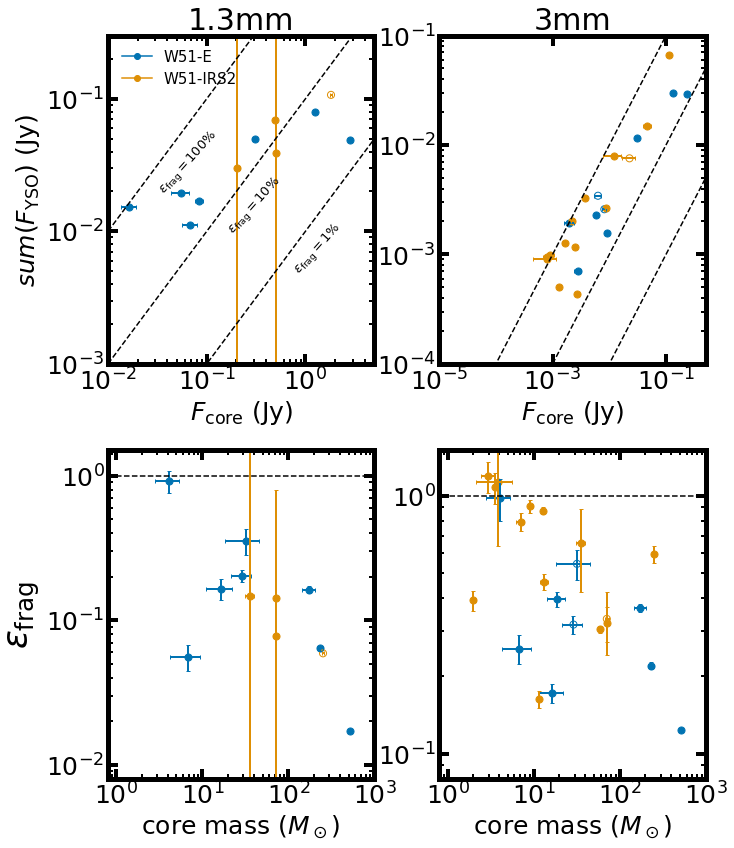

In [10]:
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, bootstrap

def plot_core_to_yso(ax, coredats, ysodats,coredats_err,ysodats_err, coremass, coremasserr, color='c'):
    epsilonset = []
    coremassset=[]
    indexset=[]
    epsilonerrset = []
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            if any(np.isfinite(ysodats[i])):
                #yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)

                epsilon = np.nansum(ysodats[i])/coredat
                sumerr = np.linalg.norm(ysodats_err[i][finiteind])
                epsilonerr = epsilon * np.sqrt((sumerr/np.nansum(ysodats[i]))**2+(coredats_err[i]/coredat)**2)
                #epsilonset.append(yerrset[0]/coredat)
                coremassset.append(coremass[i].value)
                epsilonset.append(epsilon)
                epsilonerrset.append(epsilonerr)
              
                indexset.append(i)
                """
                if any(~np.isfinite(ysodats[i])):            
                   #ax.scatter(coremass[i], yerrset[0]/coredat,color=color, marker='o', facecolor='none',s=50)
                else:
                    #ax.scatter(coremass[i], yerrset[0]/coredat,color=color,s=50) 
                """
                if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                    #ax.plot(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), color='gray', mfc=color,ls='dashed',marker='o', markersize=10)
                    ax.scatter(coremass[i], epsilon, color=color,s=50, marker='o', facecolor='none')
                    ax.errorbar(coremass[i], epsilon, 
                                xerr=coremasserr[i], 
                                yerr=epsilonerr,
                                #yerr=np.array(list(zip(ysodats_err_low_sort_finite[:-1], ysodats_err_upp_sort_finite[:-1]))).T,
                                capsize=2.0, elinewidth=2, ecolor=color,fmt='none')
                            
                else:
                    ax.scatter(coremass[i], epsilon, color=color,s=50, marker='o')

                    #ax.plot(coremass[i]*np.ones(len(ysodat_sort_finite)-1), ysodat_sort_finite[:-1]/np.nanmax(ysodats[i]), color='gray',markeredgecolor=color, mfc='none',ls='dashed',marker='o', markersize=10)
                    ax.errorbar(coremass[i], epsilon, 
                                xerr=coremasserr[i], 
                                yerr=epsilonerr,
                                #yerr=np.array(list(zip(ysodats_err_low_sort_finite[:-1], ysodats_err_upp_sort_finite[:-1]))).T,
                                capsize=2.0, elinewidth=2, ecolor=color,fmt='none')
                    
        
    
    #ax.errorbar(coremass[indexset], epsilonset,xerr=coremasserr[indexset],
    #        linestyle='',capsize=2.0, elinewidth=2, ecolor=color)
    
  
    return coremassset, epsilonset


   

def plot_eps_coremass(ax, epsdir, ysodats, coredat, coremass, coremasserr,color='k'):
    idxarr=[]
    epsilonset = []
    coremassset=[]
    eps_med = np.loadtxt(epsdir+'_eps_med.dat')
    eps_low = np.loadtxt(epsdir+'_eps_low.dat')
    eps_upp = np.loadtxt(epsdir+'_eps_upp.dat')
    j=0
    for i,ysodat in enumerate(ysodats):
        if len(ysodat)>0:
            if any(np.isfinite(ysodats[i])):
                finiteind = np.isfinite(ysodats[i])

                print(i, eps_med[j], np.sum(ysodats[i][finiteind])/coredat[i])
                epsilonset.append(eps_med[j])
                coremassset.append(coremass[i].value)
                idxarr.append(i)
                j=j+1
        
    ax.errorbar(coremass[idxarr], eps_med,xerr=coremasserr[idxarr],
                yerr=np.array(list(zip(eps_med - eps_low, 
                                                eps_upp -eps_med))).T,
            linestyle='',capsize=2.0, elinewidth=2, ecolor=color, fmt='o')
    ax.scatter(coremass[idxarr], eps_med,color=color,s=50, marker='o', facecolor='none')

    
    return coremassset, epsilonset
    
def pearson_for_bootstrap1(x, y):
    a = pearsonr(x, y)[0]
    return a
def pearson_for_bootstrap2(x, y):
    a = pearsonr(x, y)[1]
    return a                
fig = plt.figure(figsize=(10,12))
ax3 = fig.add_axes([0.14,0.1,0.37,0.38])
ax4 = fig.add_axes([0.6,0.1,0.37,0.38])

#ax3 = fig.add_axes([0.1,0.41,0.38,0.25])
#ax4 = fig.add_axes([0.58,0.41,0.38,0.25])

ax1 = fig.add_axes([0.14,0.58,0.37,0.38])
ax2 = fig.add_axes([0.6,0.58,0.37,0.38])

plot_core_yso_sum_frags(ax1, coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff, corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff,color=cmap[0])
plot_core_yso_sum_frags(ax2, coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff  ,color=cmap[0])
plot_core_yso_sum_frags(ax1, coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff, corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff  ,color=cmap[1])
plot_core_yso_sum_frags(ax2, coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff   , color=cmap[1])
#coremass_w51e_b6, eps_w51e_b6 = plot_core_to_yso(ax3, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff, corefluxerr_w51e_b6_woff,  ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff, coremass_w51e_b6_woff, coremasserr_w51e_b6_woff,color=cmap[0])
#coremass_w51e_b3, eps_w51e_b3 = plot_core_to_yso(ax4, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff, corefluxerr_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff, coremass_w51e_b3_woff ,coremasserr_w51e_b3_woff,color=cmap[0])
#coremass_w51n_b6, eps_w51n_b6 = plot_core_to_yso(ax3, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff, corefluxerr_w51n_b6_woff,  ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff,  coremass_w51n_b6_woff,coremasserr_w51n_b6_woff,color=cmap[1])
#coremass_w51n_b3, eps_w51n_b3 = plot_core_to_yso(ax4, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff, corefluxerr_w51n_b3_woff,  ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff, coremass_w51n_b3_woff,coremasserr_w51n_b3_woff, 
#                        color=cmap[1])

#coremass_w51e_b6, eps_w51e_b6 = plot_eps_coremass(ax3, '/home/t.yoo/w51/catalogue/comparison_almaimf/w51e_b6', ysoflux_w51e_b6_b6fov_woff, coreflux_w51e_b6_b6fov_woff,coremass_w51e_b6fov_woff, coremasserr_w51e_b6fov_woff,color=cmap[0])
#coremass_w51e_b3, eps_w51e_b3 = plot_eps_coremass(ax4, '/home/t.yoo/w51/catalogue/comparison_almaimf/w51e_b3', ysoflux_w51e_b3_b3fov_woff, coreflux_w51e_b3_b3fov_woff,coremass_w51e_b3fov_woff, coremasserr_w51e_b3fov_woff,color=cmap[0])
#coremass_w51n_b6, eps_w51n_b6 = plot_eps_coremass(ax3, '/home/t.yoo/w51/catalogue/comparison_almaimf/w51n_b6', ysoflux_w51n_b6_b6fov_woff, coreflux_w51n_b6_b6fov_woff,coremass_w51n_b6fov_woff, coremasserr_w51n_b6fov_woff,color=cmap[1])
#coremass_w51n_b3, eps_w51n_b3 = plot_eps_coremass(ax4, '/home/t.yoo/w51/catalogue/comparison_almaimf/w51n_b3', ysoflux_w51n_b3_b3fov_woff, coreflux_w51n_b3_b3fov_woff,coremass_w51n_b3fov_woff, coremasserr_w51n_b3fov_woff,color=cmap[1])

coremass_w51e_b6, eps_w51e_b6 = plot_core_to_yso(ax3,   coreflux_w51e_b6_b6fov_woff, ysoflux_w51e_b6_b6fov_woff,corefluxerr_w51e_b6_b6fov_woff,  ysoflux_err_w51e_b6_b6fov_woff,coremass_w51e_b6fov_woff, coremasserr_w51e_b6fov_woff,color=cmap[0])
coremass_w51e_b3, eps_w51e_b3 = plot_core_to_yso(ax4,   coreflux_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff,corefluxerr_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff,coremass_w51e_b3fov_woff, coremasserr_w51e_b3fov_woff,color=cmap[0])
coremass_w51n_b6, eps_w51n_b6 = plot_core_to_yso(ax3,   coreflux_w51n_b6_b6fov_woff, ysoflux_w51n_b6_b6fov_woff,corefluxerr_w51n_b6_b6fov_woff,  ysoflux_err_w51n_b6_b6fov_woff,coremass_w51n_b6fov_woff, coremasserr_w51n_b6fov_woff,color=cmap[1])
coremass_w51n_b3, eps_w51n_b3 = plot_core_to_yso(ax4,   coreflux_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff,corefluxerr_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff, coremass_w51n_b3fov_woff, coremasserr_w51n_b3fov_woff,color=cmap[1])

eps_b6 = np.append(eps_w51e_b6, eps_w51n_b6)
eps_b3 = np.append(eps_w51e_b3, eps_w51n_b3)

coremass_b6 = np.append(coremass_w51e_b6, coremass_w51n_b6)
coremass_b3 = np.append(coremass_w51e_b3, coremass_w51n_b3)
rng = np.random.default_rng()
rng2 = np.random.default_rng()

res_b6 = bootstrap((np.log10(coremass_b6)[np.isfinite(eps_b6)], np.log10(eps_b6)[np.isfinite(eps_b6)]), pearson_for_bootstrap1, confidence_level = 0.9, paired=True, vectorized=False, random_state=rng, n_resamples=1000) 
res_p_b6 = bootstrap((np.log10(coremass_b6)[np.isfinite(eps_b6)], np.log10(eps_b6)[np.isfinite(eps_b6)]), pearson_for_bootstrap2, confidence_level = 0.9, paired=True, vectorized=False, random_state=rng, n_resamples=1000) 

res_b3 = bootstrap((np.log10(coremass_b3)[np.isfinite(eps_b3)], np.log10(eps_b3)[np.isfinite(eps_b3)]), pearson_for_bootstrap1, confidence_level = 0.9, paired=True, vectorized=False, random_state=rng2, n_resamples=1000) 
res_p_b3 = bootstrap((np.log10(coremass_b3)[np.isfinite(eps_b3)], np.log10(eps_b3)[np.isfinite(eps_b3)]), pearson_for_bootstrap2, confidence_level = 0.9, paired=True, vectorized=False, random_state=rng2, n_resamples=1000) 

print(coremass_b6, eps_b6)
print(coremass_b3, eps_b3)
print(res_b6)
print(res_b3)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_ylim(1e-3,3e-1)
ax1.set_xlim(1e-2,5)
ax2.set_ylim(1e-4,1e-1)
ax2.set_xlim(1e-5,5e-1)
ax1.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax2.set_xlabel(r'$F_{\rm core}$ (Jy)')
ax1.set_ylabel(r'$sum(F_{\rm YSO})$ (Jy)')
#ax2.set_ylabel(r'$sum(F_{\rm YSO, 3mm})$ (Jy)')
handles, labels = plt.gca().get_legend_handles_labels()

point1 = Line2D([0], [0], label='W51-E', marker='o',color=cmap[0])
point2 = Line2D([0], [0], label='W51-IRS2', marker='o',color=cmap[1])               
handles.extend([point1,point2])

ax1.legend(fontsize=15,handles=handles, frameon=False)
ax1.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
ax2.plot([1e-5,5e-1],[1e-5,5e-1], ls='dashed', c='k')

ax1.plot([1e-2,5],[1e-3,5e-1], ls='dashed', c='k')
ax2.plot([1e-5,5e-1],[1e-6,5e-2], ls='dashed', c='k')

ax1.plot([1e-2,5],[1e-4,5e-2], ls='dashed', c='k')
ax2.plot([1e-5,5e-1],[1e-7,5e-3], ls='dashed', c='k')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.set_xscale('log')
ax4.set_yscale('log')

ax3.set_ylabel(r'$\epsilon_{\rm frag}$', fontsize=35)
#ax4.set_ylabel(r'$\epsilon_{\rm frag, 3mm}$', fontsize=35)
ax3.set_xlabel(r'core mass ($M_\odot$)')
ax4.set_xlabel(r'core mass ($M_\odot$)')

ax3.plot([1,1e3],[1,1],ls='dashed',c='k')
ax4.plot([0.1,1e3],[1,1],ls='dashed',c='k')

ax3.set_xlim(0.8,1e3)
ax4.set_xlim(0.8,1e3)
ax3.set_ylim(8e-3,1.5)
ax4.set_ylim(8e-2,1.5)

ax1.text(3e-2,2e-2,r'$\epsilon_{\rm frag}=100\%$', rotation=48,fontsize=13)
ax1.text(1.5e-1,1e-2,r'$\epsilon_{\rm frag}=10\%$', rotation=48,fontsize=13)
ax1.text(7e-1,5e-3,r'$\epsilon_{\rm frag}=1\%$', rotation=48,fontsize=13)
ax1.set_title('1.3mm',fontsize=30)
ax2.set_title('3mm',fontsize=30)
plt.savefig('epsilon_frag.png')

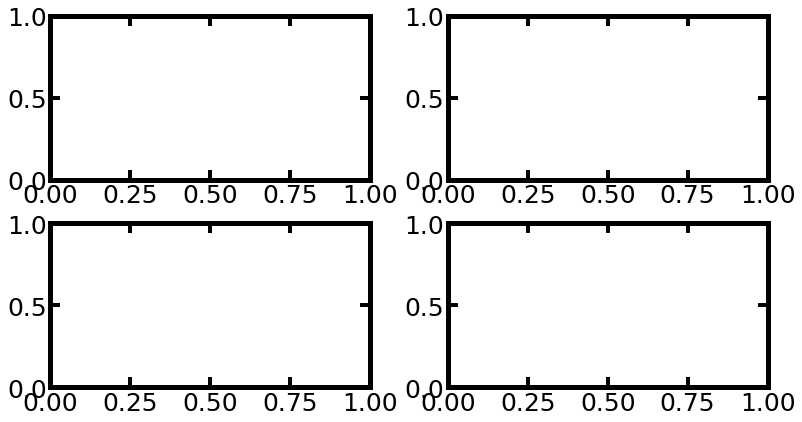

In [11]:
fig = plt.figure(figsize=(12,6))
ax3 = fig.add_axes([0.14,0.1,0.37,0.38])
ax4 = fig.add_axes([0.6,0.1,0.37,0.38])
ax1 = fig.add_axes([0.14,0.58,0.37,0.38])
ax2 = fig.add_axes([0.6,0.58,0.37,0.38])
#ax1.hist(res_b3.bootstrap_distribution[1], bins=25, density=True)
#ax2.hist(res_b6.bootstrap_distribution[1], bins=25, density=True)
#ax3.hist(res_b3.bootstrap_distribution[0], bins=25, density=True)
#ax4.hist(res_b6.bootstrap_distribution[0], bins=25, density=True)
#ax1.set_xscale('log')
#ax2.set_xscale('log')


NameError: name 'coreflux_w51e_b6_woff' is not defined

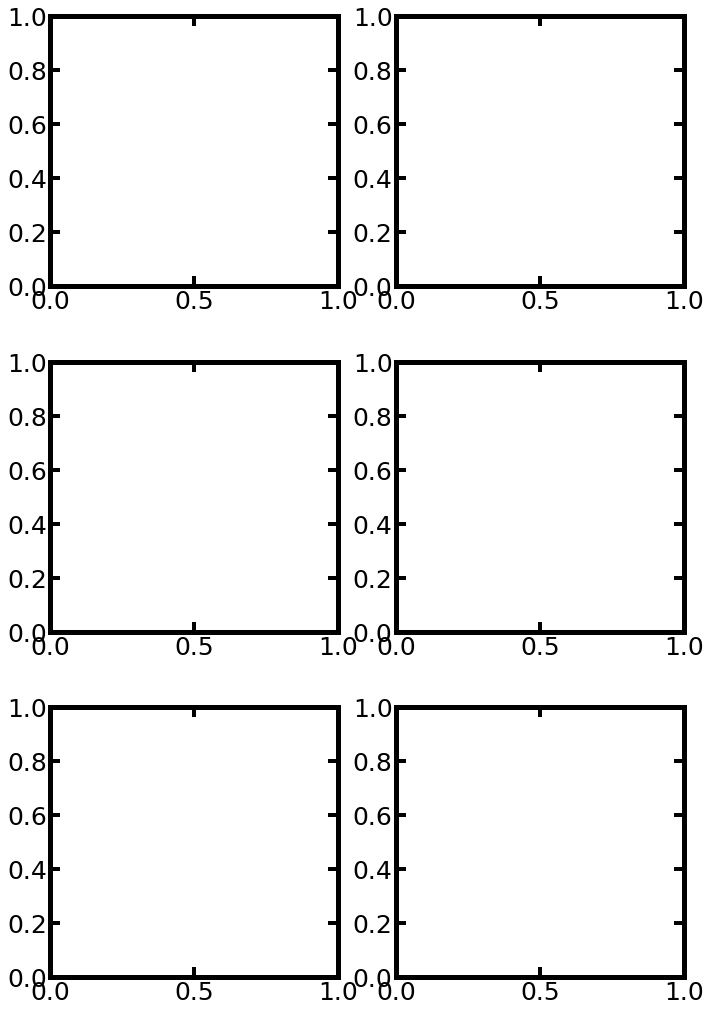

In [12]:
def plot_core_to_yso2(ax, coredats, ysodats, coredats_err,ysodats_err_low, ysodats_err_high, coremass,  color='c'):
    epsilonset = []
    indexset=[]
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)
            epsilonset.append(yerrset[0]/coredat)
            indexset.append(i)
            if any(~np.isfinite(ysodats[i])):            
                ax.scatter(coremass[i], yerrset[0]/coredat,color=color, marker='o', facecolor='none',s=50)
            else:
                ax.scatter(coremass[i], yerrset[0]/coredat,color=color,s=50)
    
                
def plot_core_nfrag(ax, coredats, ysodats, coredats_err,ysodats_err_low, ysodats_err_high, coremass,  color='c'):
    epsilonset = []
    indexset=[]
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)
            epsilonset.append(yerrset[0]/coredat)
            indexset.append(i)
            if any(~np.isfinite(ysodats[i])):            
                ax.scatter(coremass[i], len(ysodats[i]),color=color, marker='o', facecolor='none',s=50)
            else:
                ax.scatter(coremass[i], len(ysodats[i]),color=color,s=50) 
                
def plot_epsilon_nfrag(ax, coredats, ysodats, coredats_err,ysodats_err_low, ysodats_err_high, color='c'):
    epsilonset = []
    indexset=[]
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)
            epsilonset.append(yerrset[0]/coredat)
            indexset.append(i)
            if any(~np.isfinite(ysodats[i])):            
                ax.scatter(len(ysodats[i]), yerrset[0]/coredat,color=color, marker='o', facecolor='none',s=50)
            else:
                ax.scatter(len(ysodats[i]), yerrset[0]/coredat,color=color,s=50) 
    
    #ax.errorbar(coremass[indexset], epsilonset,xerr=coremasserr[indexset],
    #        linestyle='',capsize=2.0, elinewidth=2, ecolor=color)
    
fig = plt.figure(figsize=(10,15))
ax3 = fig.add_axes([0.11,0.08,0.4,0.25])
ax4 = fig.add_axes([0.59,0.08,0.4,0.25])
ax1 = fig.add_axes([0.11,0.4,0.4,0.25])
ax2 = fig.add_axes([0.59,0.4,0.4,0.25])  
ax5 = fig.add_axes([0.11,0.72,0.4,0.25])
ax6 = fig.add_axes([0.59,0.72,0.4,0.25])  

plot_epsilon_nfrag(ax5, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff, corefluxerr_w51e_b6_woff,  ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff,color=cmap[0])
plot_epsilon_nfrag(ax6, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff, corefluxerr_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff  ,color=cmap[0])
plot_epsilon_nfrag(ax5, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff, corefluxerr_w51n_b6_woff,  ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff  ,color=cmap[1])
plot_epsilon_nfrag(ax6, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff, corefluxerr_w51n_b3_woff,  ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff  , 
                        color=cmap[1])
plot_core_nfrag(ax3, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff, corefluxerr_w51e_b6_woff,  ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff,coretemp_w51e_b6_woff,color=cmap[0])
plot_core_nfrag(ax4, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff, corefluxerr_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff  ,coretemp_w51e_b3_woff,color=cmap[0])
plot_core_nfrag(ax3, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff, corefluxerr_w51n_b6_woff,  ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff  ,coretemp_w51n_b6_woff,color=cmap[1])
plot_core_nfrag(ax4, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff, corefluxerr_w51n_b3_woff,  ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff  ,coretemp_w51n_b3_woff, 
                        color=cmap[1])
plot_core_to_yso2(ax1, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff, corefluxerr_w51e_b6_woff,  ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff, coretemp_w51e_b6_woff, color=cmap[0])
plot_core_to_yso2(ax2, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff, corefluxerr_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff, coretemp_w51e_b3_woff ,color=cmap[0])
plot_core_to_yso2(ax1, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff, corefluxerr_w51n_b6_woff,  ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff,  coretemp_w51n_b6_woff,color=cmap[1])
plot_core_to_yso2(ax2, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff, corefluxerr_w51n_b3_woff,  ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff, coretemp_w51n_b3_woff, 
                        color=cmap[1])
ax5.set_title('1.3mm',fontsize=30)
ax6.set_title('3mm',fontsize=30)
ax5.set_xlabel('$N_{frag}$')
ax6.set_xlabel('$N_{frag}$')
ax5.set_ylabel(r'$\epsilon_{frag}$',fontsize=30)
#ax6.set_ylabel(r'$\epsilon_{frag, 3mm}$')
ax3.set_xlabel('$T_{core}$')
ax4.set_xlabel('$T_{core}$')
ax3.set_xlim(10,90)
ax4.set_xlim(10,90)
ax1.set_xlim(10,90)
ax2.set_xlim(10,90)
ax5.set_xlim(0,7)
ax6.set_xlim(0,7)
ax5.set_ylim(-0.05,1.5)
ax6.set_ylim(-0.05,1.5)
ax1.set_ylim(-0.05,1.5)
ax2.set_ylim(-0.05,1.5)
ax3.set_ylim(0,7)
ax4.set_ylim(0,7)
ax5.set_xticks([0,2,4,6])
ax6.set_xticks([0,2,4,6])
ax5.set_yticks([0,0.5,1,1.5])
ax6.set_yticks([0,0.5,1,1.5])

ax6.legend(fontsize=15,handles=handles, frameon=False)
ax3.set_ylabel('$N_{frag}$')
#ax4.set_ylabel('$N_{frag}$')
ax1.set_xlabel('$T_{core}$')
ax2.set_xlabel('$T_{core}$')
ax1.set_ylabel(r'$\epsilon_{frag}$',fontsize=30)
#ax2.set_ylabel(r'$\epsilon_{frag, 3mm}$')
plt.savefig('epsilon_nfrag.png')

Text(0.5, 1.0, '3mm')

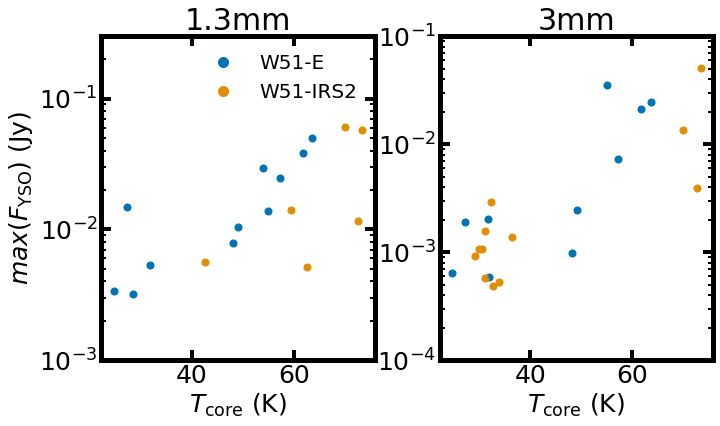

In [20]:
fig = plt.figure(figsize=(10,6))
ax5 = fig.add_axes([0.14,0.17,0.38,0.75])
ax6 = fig.add_axes([0.61,0.17,0.38,0.75])
def plot_core_yso_max_frags2(ax, coredats, ysodats, ysodats_err_low, ysodats_err_high, color='c'):
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                ax.errorbar(coredat, np.nanmax(ysodats[i]),  
                                yerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                            capsize=2.0, elinewidth=2, ecolor=color)
                ax.scatter(coredat, np.nanmax(ysodats[i]),color=color,s=50)
plot_core_yso_max_frags2(ax5, coretemp_w51e_b6_woff, ysoflux_w51e_b6_woff,   ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff,color=cmap[0])
plot_core_yso_max_frags2(ax6, coretemp_w51e_b3_woff, ysoflux_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff  ,color=cmap[0])
plot_core_yso_max_frags2(ax5, coretemp_w51n_b6_woff, ysoflux_w51n_b6_woff,   ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff  ,color=cmap[1])
plot_core_yso_max_frags2(ax6, coretemp_w51n_b3_woff, ysoflux_w51n_b3_woff,   ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff  ,   color=cmap[1])
#ax5.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
#ax6.plot([5e-4,5e-1],[5e-4,5e-1], ls='dashed', c='k')
                    
#ax5.set_xscale('log')
ax5.set_yscale('log')
#ax6.set_xscale('log')
ax6.set_yscale('log')
ax5.set_ylim(1e-3,3e-1)
#ax5.set_xlim(1e-2,5)
ax6.set_ylim(1e-4,1e-1)

#ax6.set_xlim(5e-4,5e-1)
ax5.set_xlabel(r'$T_{\rm core}$ (K)')
ax6.set_xlabel(r'$T_{\rm core}$ (K)')
ax5.set_ylabel(r'$max(F_{\rm YSO})$ (Jy)')
#ax6.set_ylabel(r'$max(F_{\rm YSO, 3mm})$ (Jy)')

handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax5.legend(handles=handles,fontsize=20, frameon=False)
ax5.set_title('1.3mm',fontsize=30)
ax6.set_title('3mm',fontsize=30)


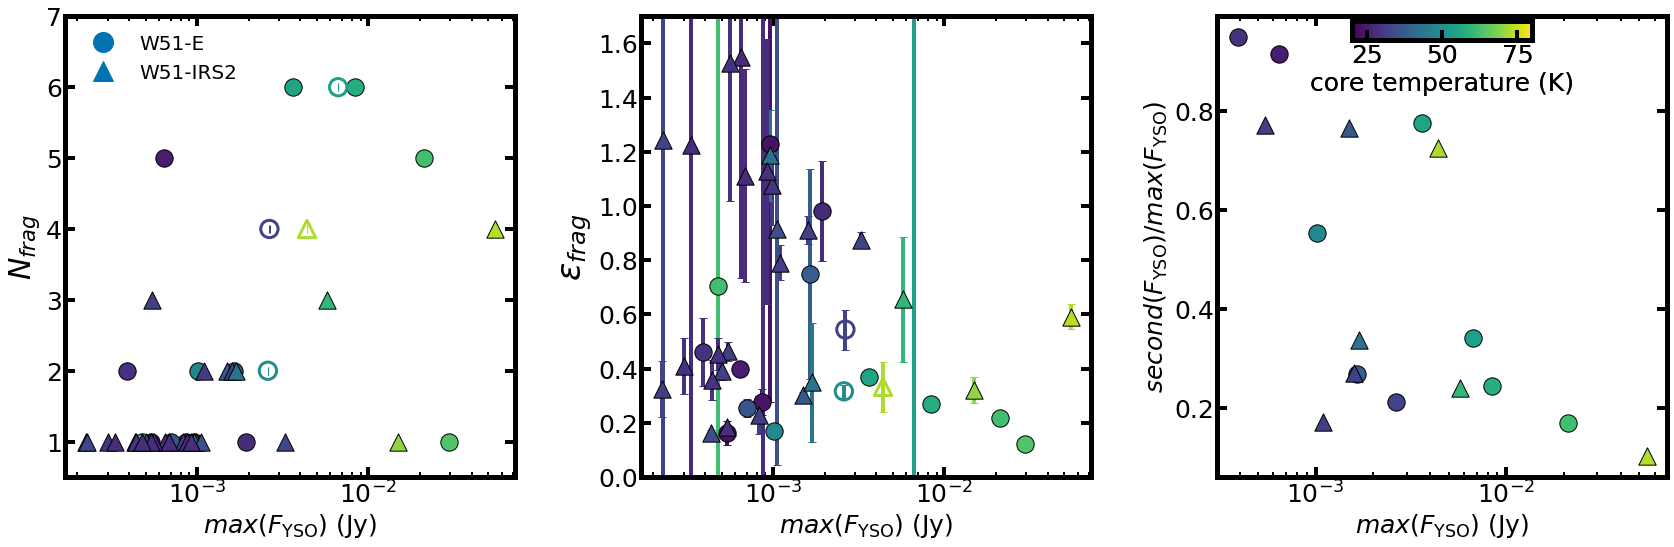

In [150]:
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_maxyso_frag(ax1, ax2, ax3, epsdir, coredats, ysodats, ysodats_err_low, ysodats_err_high,coretemp, marker='o'):
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = matplotlib.colors.Normalize(vmin=20, vmax=80, clip=True)
   
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    color = np.array([(mapper.to_rgba(v)) for v in coretemp])
    
    eps_med = np.loadtxt(epsdir+'_eps_med.dat')
    eps_low = np.loadtxt(epsdir+'_eps_low.dat')
    eps_upp = np.loadtxt(epsdir+'_eps_upp.dat')
    j=0
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            #eps = np.sum(np.nansum(ysodats[i]))/coredats[i]
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                ax1.errorbar(np.nanmax(ysodats[i]), lenx, 
                                xerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                            capsize=4.0, elinewidth=4, color=color[i])
                if any(~np.isfinite(ysodats[i])):            
                    ax1.scatter(np.nanmax(ysodats[i]), lenx, color=color[i],  facecolor='none',s=300,marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50, lw=3)
                else:
                    ax1.scatter(np.nanmax(ysodats[i]), lenx, edgecolors='k',color=color[i],s=300, marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50)
                
                ax2.errorbar(np.nanmax(ysodats[i]), eps_med[j], 
                                xerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                             yerr=np.array([[eps_med[j]-eps_low[j], eps_upp[j]-eps_med[j]]]).T,
                            capsize=4.0, elinewidth=4, color=color[i])
                if any(~np.isfinite(ysodats[i])):            
                    ax2.scatter(np.nanmax(ysodats[i]), eps_med[j], color=color[i],  facecolor='none',s=300,marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50, lw=3)
                else:
                    pp=ax2.scatter(np.nanmax(ysodats[i]), eps_med[j], edgecolors='k',color=color[i],s=300, marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50)
                
                if len(np.where(np.isfinite(ysodats[i])==True)[0])>1:
                    ysodats_finite = ysodats[i][np.isfinite(ysodats[i])]
                    ysodats_sort = np.sort(ysodats_finite)
                    ax3.scatter(np.nanmax(ysodats[i]), ysodats_sort[-2]/np.nanmax(ysodats[i]), color=color[i], edgecolors='k', s=300, marker=marker, vmin=20, vmax=80, cmap=cmap )
                j=j+1
    axins1 = inset_axes(
    ax2,
    width="40%",  # width: 50% of parent_bbox width
    height="4%",  # height: 5%
    loc="upper center",)
    axins1.xaxis.set_ticks_position("bottom")
    axcbr = fig.colorbar(mapper, cax=axins1, orientation="horizontal", )
    axcbr.set_label('core temperature (K)', )


def plot_maxyso_frag2(ax1, ax2, ax3, coredats, coredats_err, ysodats, ysodats_err,coretemp, marker='o'):
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = matplotlib.colors.Normalize(vmin=20, vmax=80, clip=True)
   
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    color = np.array([(mapper.to_rgba(v)) for v in coretemp])
    
    
    
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            finiteind = np.isfinite(ysodats[i])
            lenx = len(ysodats[i])
            epsilon = np.nansum(ysodats[i])/coredat
            sumerr = np.linalg.norm(ysodats_err[i][finiteind])
            epsilonerr = epsilon * np.sqrt((sumerr/np.nansum(ysodats[i]))**2+(coredats_err[i]/coredat)**2)
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                ax1.errorbar(np.nanmax(ysodats[i]), lenx, 
                                xerr=ysodats_err[i][maxidx],
                            capsize=4.0, elinewidth=4, color=color[i])
                if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                    ax1.scatter(np.nanmax(ysodats[i]), lenx, color=color[i],  facecolor='none',s=300,marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50, lw=3)
                else:
                    ax1.scatter(np.nanmax(ysodats[i]), lenx, edgecolors='k',color=color[i],s=300, marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50)
                
                ax2.errorbar(np.nanmax(ysodats[i]), epsilon, 
                                xerr=ysodats_err[i][maxidx],
                             yerr=epsilonerr,
                            capsize=4.0, elinewidth=4, color=color[i])
                if len(np.where(np.isfinite(ysodats[i])==True)[0])!=len(ysodats[i]):
                    ax2.scatter(np.nanmax(ysodats[i]), epsilon, color=color[i],  facecolor='none',s=300,marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50, lw=3)
                else:
                    pp=ax2.scatter(np.nanmax(ysodats[i]), epsilon, edgecolors='k',color=color[i],s=300, marker=marker,vmin=20,vmax=80,cmap=cmap,zorder=50)
                
                if len(np.where(np.isfinite(ysodats[i])==True)[0])>1:
                    ysodats_finite = ysodats[i][np.isfinite(ysodats[i])]
                    ysodats_sort = np.sort(ysodats_finite)
                    ax3.scatter(np.nanmax(ysodats[i]), ysodats_sort[-2]/np.nanmax(ysodats[i]), color=color[i], edgecolors='k', s=300, marker=marker, vmin=20, vmax=80, cmap=cmap )
               
    axins1 = inset_axes(
    ax3,
    width="40%",  # width: 50% of parent_bbox width
    height="4%",  # height: 5%
    loc="upper center",)
    axins1.xaxis.set_ticks_position("bottom")
    axcbr = fig.colorbar(mapper, cax=axins1, orientation="horizontal", )
    axcbr.set_label('core temperature (K)', )

fig = plt.figure(figsize=(25,8))
ax1 = fig.add_axes([0.08,0.15,0.25,0.8])
ax2 = fig.add_axes([0.4,0.15,0.25,0.8])
ax3 = fig.add_axes([0.72,0.15,0.25,0.8])

plot_maxyso_frag2(ax1, ax2,ax3,  coreflux_w51e_b3_b3fov_woff, corefluxerr_w51e_b3_b3fov_woff, ysoflux_w51e_b3_b3fov_woff,  ysoflux_err_w51e_b3_b3fov_woff,  coretemp_w51e_b3fov_woff, marker='o')
plot_maxyso_frag2(ax1, ax2,ax3,  coreflux_w51n_b3_b3fov_woff, corefluxerr_w51n_b3_b3fov_woff, ysoflux_w51n_b3_b3fov_woff,  ysoflux_err_w51n_b3_b3fov_woff,  coretemp_w51n_b3fov_woff, marker='^')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r'$max(F_{\rm YSO})$ (Jy)')

ax2.set_xlabel(r'$max(F_{\rm YSO})$ (Jy)')
ax1.set_xlabel(r'$max(F_{\rm YSO})$ (Jy)')
ax1.set_ylabel('$N_{frag}$',fontsize=30)
ax2.set_ylabel(r'$\epsilon_{frag}$',fontsize=34)
ax3.set_ylabel(r'$second(F_{\rm YSO})/max(F_{\rm YSO})$')

handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=20, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='^', markersize=20, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
handles.extend([dummy_w51e, dummy_w51n])
ax1.legend(handles=handles,fontsize=20, frameon=False)
ax1.set_ylim(0.5,7)
ax2.set_ylim(0,1.7)

plt.savefig('n_frag_e_frag.png')

Text(0.5, 1.0, '3mm')

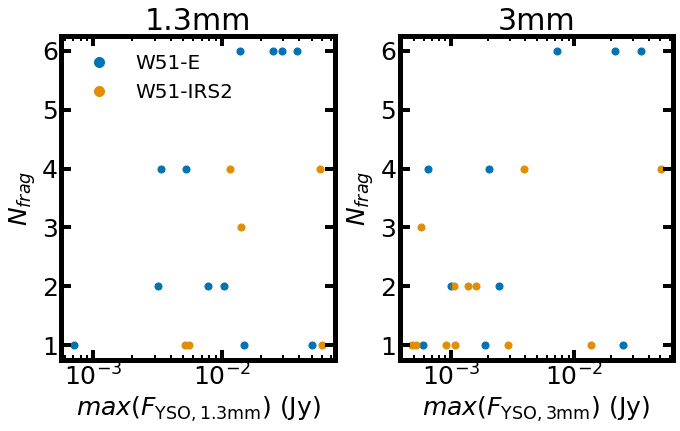

In [22]:
def plot_core_yso_max_nfrags(ax, coredats,ysodats, ysodats_err_low, ysodats_err_high, color='c'):
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                ax.errorbar(np.nanmax(ysodats[i]), len(ysodats[i]), 
                                xerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                            capsize=2.0, elinewidth=2, ecolor=color)
                ax.scatter(np.nanmax(ysodats[i]),len(ysodats[i]),color=color,s=50)
                
fig = plt.figure(figsize=(10,6))
ax5 = fig.add_axes([0.14,0.17,0.38,0.75])
ax6 = fig.add_axes([0.61,0.17,0.38,0.75])

plot_core_yso_max_nfrags(ax5, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff,   ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff,color=cmap[0])
plot_core_yso_max_nfrags(ax6, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff  ,color=cmap[0])
plot_core_yso_max_nfrags(ax5, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff,   ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff  ,color=cmap[1])
plot_core_yso_max_nfrags(ax6, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff,   ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff  ,   color=cmap[1])
#ax5.plot([1e-2,5],[1e-2,5], ls='dashed', c='k')
#ax6.plot([5e-4,5e-1],[5e-4,5e-1], ls='dashed', c='k')
                    
ax5.set_xscale('log')
#ax5.set_yscale('log')
ax6.set_xscale('log')
#ax6.set_yscale('log')
#ax5.set_ylim(1e-3,3e-1)
#ax5.set_xlim(1e-2,5)
#ax6.set_ylim(1e-4,1e-1)

#ax6.set_xlim(5e-4,5e-1)
ax5.set_xlabel(r'$max(F_{\rm YSO, 1.3mm})$ (Jy)')
ax6.set_xlabel(r'$max(F_{\rm YSO, 3mm})$ (Jy)')
#ax6.set_ylabel(r'$max(F_{\rm YSO, 3mm})$ (Jy)')
ax5.set_ylabel('$N_{frag}$')
ax6.set_ylabel('$N_{frag}$')
handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax5.legend(handles=handles,fontsize=20, frameon=False)
ax5.set_title('1.3mm',fontsize=30)
ax6.set_title('3mm',fontsize=30)
                

In [23]:
def plot_core_yso_max_efrags(ax, coredats,ysodats, ysodats_err_low, ysodats_err_high, color='c'):
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            if any(np.isfinite(ysodats[i])):
                maxidx = np.nanargmax(ysodats[i])
                ax.errorbar(np.nanmax(ysodats[i]), len(ysodats[i]), 
                                xerr=np.array([[ysodats[i][maxidx] - ysodats_err_low[i][maxidx], 
                                                ysodats_err_high[i][maxidx] - ysodats[i][maxidx]]]).T,
                            capsize=2.0, elinewidth=2, ecolor=color)
                ax.scatter(np.nanmax(ysodats[i]),len(ysodats[i]),color=color,s=50)
plot_core_yso_max_efrags(ax5, coreflux_w51e_b6_woff, ysoflux_w51e_b6_woff,   ysoflux_lowerr_w51e_b6_woff, ysoflux_upperr_w51e_b6_woff,color=cmap[0])
plot_core_yso_max_efrags(ax6, coreflux_w51e_b3_woff, ysoflux_w51e_b3_woff,  ysoflux_lowerr_w51e_b3_woff, ysoflux_upperr_w51e_b3_woff  ,color=cmap[0])
plot_core_yso_max_efrags(ax5, coreflux_w51n_b6_woff, ysoflux_w51n_b6_woff,   ysoflux_lowerr_w51n_b6_woff, ysoflux_upperr_w51n_b6_woff  ,color=cmap[1])
plot_core_yso_max_efrags(ax6, coreflux_w51n_b3_woff, ysoflux_w51n_b3_woff,   ysoflux_lowerr_w51n_b3_woff, ysoflux_upperr_w51n_b3_woff  ,   color=cmap[1])


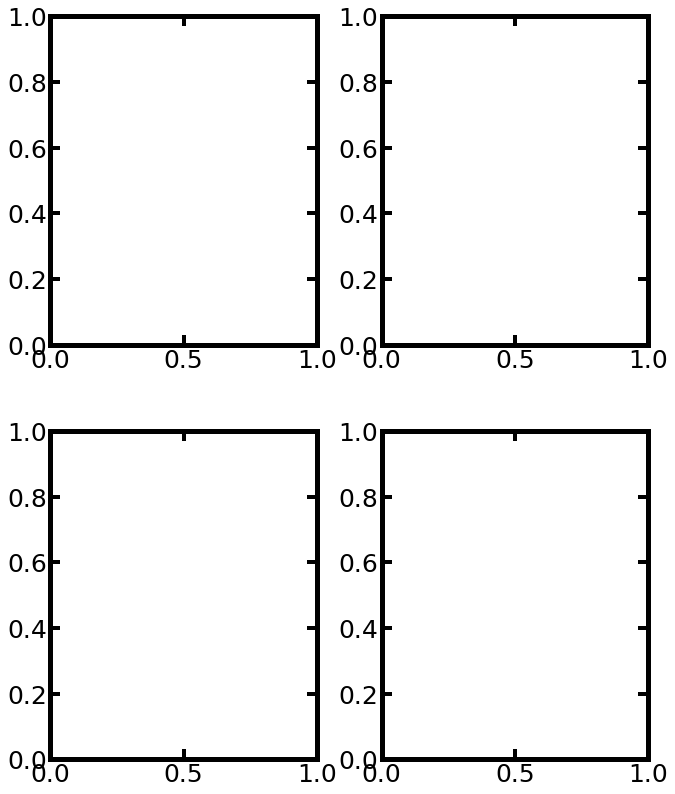

In [24]:
def plot_core_eps_nfrag(ax, coredats, ysodats, coredats_err,ysodats_err_low, ysodats_err_high, coremass,  color='c'):
    epsilonset = []
    indexset=[]
    for i, coredat in enumerate(coredats):
        
        if len(ysodats[i])>0:
            lenx = len(ysodats[i])
            finiteind = np.isfinite(ysodats[i])
            yerrset = add_asym.add_asym(ysodats[i][finiteind], ysodats[i][finiteind]-ysodats_err_low[i][finiteind], ysodats_err_high[i][finiteind]-ysodats[i][finiteind], order=1)
            epsilonset.append(yerrset[0]/coredat)
            indexset.append(i)
            if any(~np.isfinite(ysodats[i])):            
                ax.scatter(coremass[i], len(ysodats[i]),color=color, marker='o', facecolor='none',s=50)
            else:
                ax.scatter(coremass[i], len(ysodats[i]),color=color,s=50)
fig = plt.figure(figsize=(10,12))
ax3 = fig.add_axes([0.14,0.1,0.37,0.38])
ax4 = fig.add_axes([0.6,0.1,0.37,0.38])

#ax3 = fig.add_axes([0.1,0.41,0.38,0.25])
#ax4 = fig.add_axes([0.58,0.41,0.38,0.25])

ax1 = fig.add_axes([0.14,0.58,0.37,0.38])
ax2 = fig.add_axes([0.6,0.58,0.37,0.38])









*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

0.0001789690324610076 0.00021877935669236526 0.00016728098851400897 0.00016728098851400897
0 0.0005511951605325625 0.0008995508782398465
0 0.0005511951605325625 0.0008995508782398465
1 0.0007569824800840809 0.0012050710926858736
1 0.0007569824800840809 0.0012050710926858736
2 0.0003437405271420897 0.0007814670466273856
2 0.0003437405271420897 0.0007814670466273856
3 0.0005049938585454493 0.0004235983096977461
3 0.0005049938585454493 0.0004235983096977461
4 0.0006961232836909524 0.000887363732108009
4 0.0006961232836909524 0.000887363732108009
5 0.00038651951624793827 0.00010938967834618263
5 0.00038651951624793827 0.00010938967834618263
6 0.000279192064708714 0.00010938967834618263
6 0.000279192064708714 0.00010938967834618263
7 0.0003118052149093368 0.0004342233826018175
7 0.0003118052149093368 0.0004342233826018175
8 0.0009306383488687765 0.0007851985521978655
8 0.0009306383488687765 0.0007851985521978655
9 0.0009586294588754596 0.0011298175202866616
9 0.0009586294588754596 0.0011298

Text(0, 0.5, '$F_{YSO, 3mm}/F_{core, 3mm}$')

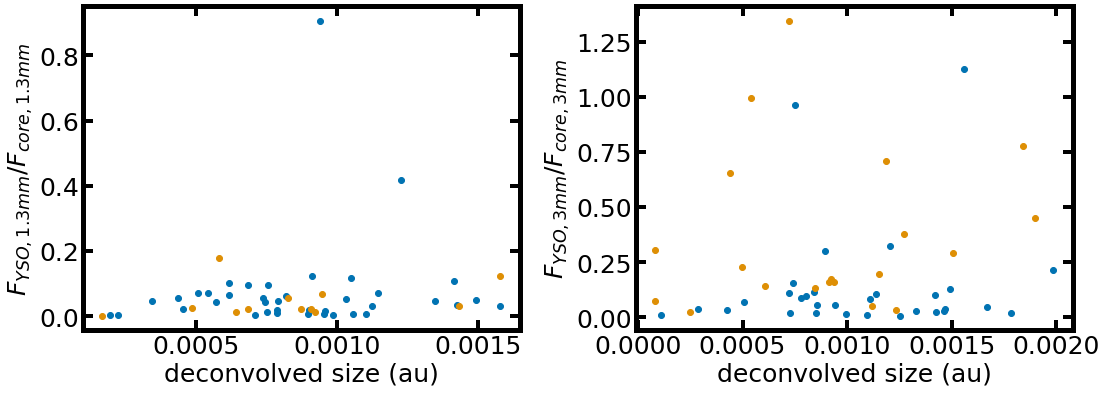

In [25]:
ysosize_b6_w51e = np.sqrt(catalog_w51e_yso['deconvolved_major_b6'].value * catalog_w51e_yso['deconvolved_minor_b6'].value) * 2 / 2.355 * np.pi/180 * 5.41*1000*206265*4.84814e-6
ysosize_b3_w51e = np.sqrt(catalog_w51e_yso['deconvolved_major_b3'].value * catalog_w51e_yso['deconvolved_minor_b3'].value)* 2 / 2.355 * np.pi/180 * 5.41*1000*206265*4.84814e-6
ysosize_b6_w51n = np.sqrt(catalog_w51n_yso['deconvolved_major_b6'].value * catalog_w51n_yso['deconvolved_minor_b6'].value)* 2 / 2.355 * np.pi/180 * 5.1*1000*206265*4.84814e-6
ysosize_b3_w51n = np.sqrt(catalog_w51n_yso['deconvolved_major_b3'].value * catalog_w51n_yso['deconvolved_minor_b3'].value)* 2 / 2.355 * np.pi/180 * 5.1*1000*206265*4.84814e-6

ysosize_b6_w51e_min = np.min(ysosize_b6_w51e[ysosize_b6_w51e>0])
ysosize_b3_w51e_min = np.min(ysosize_b3_w51e[ysosize_b3_w51e>0])
ysosize_b6_w51n_min = np.min(ysosize_b6_w51n[ysosize_b6_w51n>0])
ysosize_b3_w51n_min = np.min(ysosize_b6_w51n[ysosize_b3_w51n>0])

w51e_unresolved = np.logical_or(ysosize_b6_w51e==0, ysosize_b6_w51e==0)
w51n_unresolved = np.logical_or(ysosize_b6_w51n==0, ysosize_b6_w51n==0)

ysosize_b6_w51e[ysosize_b6_w51e==0] = ysosize_b6_w51e_min/2
ysosize_b3_w51e[ysosize_b3_w51e==0] = ysosize_b3_w51e_min/2
ysosize_b6_w51n[ysosize_b6_w51n==0] = ysosize_b6_w51n_min/2
ysosize_b3_w51n[ysosize_b3_w51n==0] = ysosize_b3_w51n_min/2


print(ysosize_b6_w51e_min,ysosize_b3_w51e_min,ysosize_b6_w51n_min,ysosize_b3_w51n_min)

def get_avg_sizes(b3size, b6size):
    avgsize=[]
    for i in range(len(b6size)):
        b6size_selected = b6size[i]
        b3size_selected = b3size[i]
        print(i,b6size_selected,b3size_selected)
        if not np.isfinite(b6size_selected):
            b6size_selected = b3size_selected
        if not np.isfinite(b3size_selected):
            b3size_selected = b6size_selected
        print(i,b6size_selected,b3size_selected)

        avgsize.append(np.mean([b6size_selected, b3size_selected]))
    
    return np.array(avgsize)
    
#find sources of which sizes are nan (undetected) or 0 (not resolved)
ysosize_avg_w51e = get_avg_sizes(ysosize_b3_w51e, ysosize_b6_w51e)
ysosize_avg_w51n = get_avg_sizes(ysosize_b3_w51n, ysosize_b6_w51n)

print(ysosize_b6_w51e.mask)


#ysosize_avg_w51e = np.mean(np.vstack((ysosize_b6_w51e, ysosize_b3_w51e)),axis=0)
#ysosize_avg_w51n = np.mean(np.vstack((ysosize_b6_w51n, ysosize_b3_w51n)),axis=0)

ysosize_w51e_b6_woff = [ysosize_b6_w51e[ind].data for ind in ysoindarr_w51e_woff]
ysosize_w51e_b3_woff = [ysosize_b3_w51e[ind].data for ind in ysoindarr_w51e_woff_b3] 
print(len(ysosize_w51e_b6_woff))

ysosize_w51n_b6_woff = [ysosize_b6_w51n[ind].data for ind in ysoindarr_w51n_woff]
ysosize_w51n_b3_woff = [ysosize_b3_w51n[ind].data for ind in ysoindarr_w51n_woff_b3]

ysosize_w51e_avg_woff = [ysosize_avg_w51e[ind].data for ind in ysoindarr_w51e_woff]
ysosize_w51n_avg_woff = [ysosize_avg_w51n[ind].data for ind in ysoindarr_w51n_woff]

ysosize_w51e_avg_wff = [ysosize_avg_w51e[ind].data for ind in ysoindarr_w51e_wff]
ysosize_w51n_avg_wff = [ysosize_avg_w51n[ind].data for ind in ysoindarr_w51n_b6fov_wff]




ysosize_w51e_b6_woff_flat = [item for sublist in ysosize_w51e_b6_woff for item in sublist]
ysosize_w51e_b3_woff_flat = [item for sublist in ysosize_w51e_b3_woff for item in sublist]
ysosize_w51n_b6_woff_flat = [item for sublist in ysosize_w51n_b6_woff for item in sublist]
ysosize_w51n_b3_woff_flat = [item for sublist in ysosize_w51n_b3_woff for item in sublist]

fluxratio_w51e_b6_woff_flat = [ysoflux/coreflux_w51e_b6_woff[i] for i, sublist in enumerate(ysoflux_w51e_b6_woff) for ysoflux in sublist]
fluxratio_w51e_b3_woff_flat = [ysoflux/coreflux_w51e_b3_woff[i] for i, sublist in enumerate(ysoflux_w51e_b3_woff) for ysoflux in sublist]
fluxratio_w51n_b6_woff_flat = [ysoflux/coreflux_w51n_b6_woff[i] for i, sublist in enumerate(ysoflux_w51n_b6_woff) for ysoflux in sublist]
fluxratio_w51n_b3_woff_flat = [ysoflux/coreflux_w51n_b3_woff[i] for i, sublist in enumerate(ysoflux_w51n_b3_woff) for ysoflux in sublist]

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_axes([0.1,0.17,0.38,0.75])
ax2 = fig.add_axes([0.58,0.17,0.38,0.75])


ax1.scatter(ysosize_w51e_b6_woff_flat, fluxratio_w51e_b6_woff_flat, c=cmap[0])
ax1.scatter(ysosize_w51n_b6_woff_flat, fluxratio_w51n_b6_woff_flat, c=cmap[1])
ax2.scatter(ysosize_w51e_b3_woff_flat, fluxratio_w51e_b3_woff_flat, c=cmap[0])
ax2.scatter(ysosize_w51n_b3_woff_flat, fluxratio_w51n_b3_woff_flat, c=cmap[1])

ax1.set_xlabel('deconvolved size (au)')
ax1.set_ylabel('$F_{YSO, 1.3mm}/F_{core, 1.3mm}$')

ax2.set_xlabel('deconvolved size (au)')
ax2.set_ylabel('$F_{YSO, 3mm}/F_{core, 3mm}$')



In [ ]:
import csv
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

def plot_core_yso_frag_rates(ax, coredats, ysodats, color='r', marker='o'):
    #coredats, ysodats -> size
    print(len(coredats),len(ysodats))
    for i, coredat in enumerate(coredats):
        if len(ysodats[i])>0:
            phi_2d = np.log(len(ysodats[i])) / np.log(coredat/np.mean(ysodats[i]))
            phi_3d = phi_2d / 0.7
            print(len(ysodats[i]), coredat, np.mean(ysodats[i]), phi_3d)
            ax.scatter(coredat, phi_3d, color=color,s=30, marker=marker)
            

dat = np.loadtxt(open("../model/fragmentation_table.csv", "rb"), delimiter=",", skiprows=1)
scale_tab = dat[:,0]
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])

cmap2=sns.color_palette("viridis", as_cmap=True)

norm = mpl.colors.Normalize(vmin=0, vmax=9, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap2)
color= np.array([(mapper.to_rgba(v)) for v in range(9)])
#cmap2= plt.get_cmap('bkr',9)
xiarr = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0]
for i in range(9):
    xscale = 10 * 1.5
    yscale = 8*2
    ax1.plot(scale_tab, dat[:,i+1], color=color[i])
    ind = np.argmin(np.abs(scale_tab-0.04))
    rotn = np.arctan2((dat[ind+1,i+1]-dat[ind,i+1])*yscale, 
                      (np.log10(scale_tab[ind+1])-np.log10(scale_tab[ind]))*xscale)*(180)/np.pi+180
    ax1.annotate(r'$\xi=%3.2f$'%xiarr[i], xy=(0.04,dat[ind,i+1]-0.1), rotation=rotn, fontsize=20, annotation_clip=True)
    print(i,dat[ind,i+1], rotn)

    print(cmap2(i))

coresize_w51e_b6_woff = size_w51e_b6[coreindarr_w51e_b6fov_woff]
coresize_w51e_b3_woff = size_w51e_b3[coreindarr_w51e_b3fov_woff]

coresize_w51n_b6_woff = size_w51n_b6[coreindarr_w51n_b6fov_woff]
coresize_w51n_b3_woff = size_w51n_b3[coreindarr_w51n_b3fov_woff]
print(ysosize_w51e_b6_woff)

#ysosize_w51e_avg_woff = np.nanmean(np.vstack([ysosize_w51e_b6_woff, ysosize_w51e_b3_woff])*4.84814e-6, axis=1)
#ysosize_w51n_avg_woff = np.nanmean(np.vstack([ysosize_w51n_b6_woff, ysosize_w51n_b3_woff])*4.84814e-6, axis=1)

coresize_w51e_b6_wff = size_w51e_b6[coreindarr_w51e_wff]
coresize_w51e_b3_wff = size_w51e_b3[coreindarr_w51e_b3fov_wff]

coresize_w51n_b6_wff = size_w51n_b6[coreindarr_w51n_b6fov_wff]
coresize_w51n_b3_wff = size_w51n_b3[coreindarr_w51n_b3fov_wff]

#ysosize_w51e_avg_wff = np.nanmean(np.vstack([ysosize_w51e_b6_wff, ysosize_w51e_b3_wff])*4.84814e-6, axis=1)
#ysosize_w51n_avg_wff = np.nanmean(np.vstack([ysosize_w51n_b6_wff, ysosize_w51n_b3_wff])*4.84814e-6, axis=1)

plot_core_yso_frag_rates(ax1, coresize_w51e_b6_woff*4.84814e-6, ysosize_w51e_avg_woff, color=cmap[0])
plot_core_yso_frag_rates(ax1, coresize_w51n_b6_woff*4.84814e-6, ysosize_w51n_avg_woff, color=cmap[1])
plot_core_yso_frag_rates(ax1, coresize_w51e_b6_wff*4.84814e-6, ysosize_w51e_avg_wff, color=cmap[0], marker='x')
plot_core_yso_frag_rates(ax1, coresize_w51n_b6_wff*4.84814e-6, ysosize_w51n_avg_wff, color=cmap[1], marker='x')
ax1.hlines(5e-5,1,-1,color='k',ls='dashed',lw=3)
ax1.set_xscale('log')
ax1.set_xlabel('R (pc)')
ax1.set_ylabel(r'$\phi$ (fragmentation rate)')
ax1.set_ylim(-0.5,1.5)
ax1.set_xlim(1e-3,1e-1)